# Visualisation des données de la campagne "visite panier" de l'annonceur 2

## Visualisation des données brutes

In [2]:
# fichiers contenant les fonctions utiles
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels
from premiere_analyse import *
from part1 import *
from part2 import *
from part3 import *
from testZ import *
import scipy.stats as st
import statsmodels.stats as sms
from IPython.display import display, Markdown
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import statsmodels.tsa.stattools as sto
from pandas import DataFrame
import seaborn as sns
import warnings

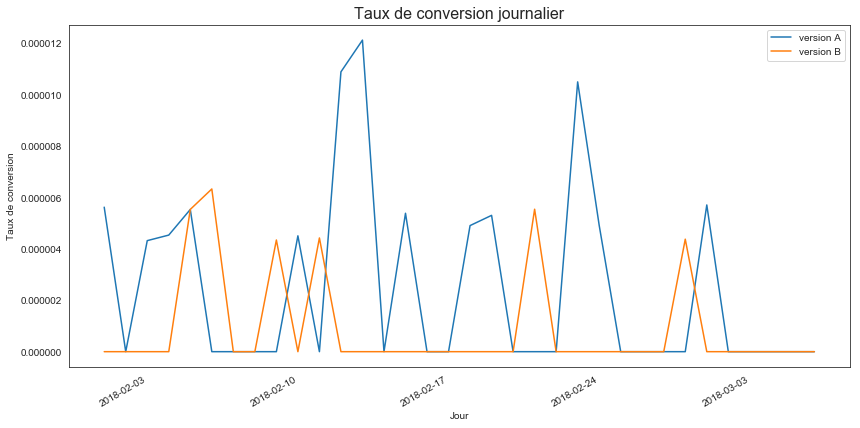

In [3]:
datasetA = pd.read_hdf('/Users/guillaumeshi/PycharmProjects/1000mercis/Data/annonceur2/annonceur2_daily.hdf', key='visite_panierA')
datasetB = pd.read_hdf('/Users/guillaumeshi/PycharmProjects/1000mercis/Data/annonceur2/annonceur2_daily.hdf', key='visite_panierB')
plt.rcParams["figure.figsize"] = (14,7)
fig, ax = plt.subplots()
fig.autofmt_xdate()
ax.plot_date(datasetA.index, datasetA['conv_rate'], marker='', linestyle='-')
plt.plot(datasetA.index, datasetB['conv_rate'])
plt.xlabel('Jour')
plt.ylabel('Taux de conversion')
plt.title('Taux de conversion journalier', fontsize=16)
plt.legend(['version A', 'version B'], loc='best')
plt.show()

La version A semble ainsi plus efficace que la version B dans la mesure où les taux de conversion sont quasiment toujours supérieurs ou égaux à ceux de la version B. Il reste à voir si cette observation est statistiquement significative, d'où la nécessité d'un test d'hypothèses.

## Différence relative des taux de conversion

Dans le cadre de cette campagne, étudier la différence relative journalière des taux de conversion s'avère compliqué. En effet, les taux de conversions sont régulièrement nuls (presque la moitié du temps pour les deux versions A et B), si bien que le calcul d'une différence relative d'un point de vue quotidien ne fait pas beaucoup de sens. En revanche, une agrégation des données à une maille hebdomadaire permet de mieux visualiser cette différence relative.

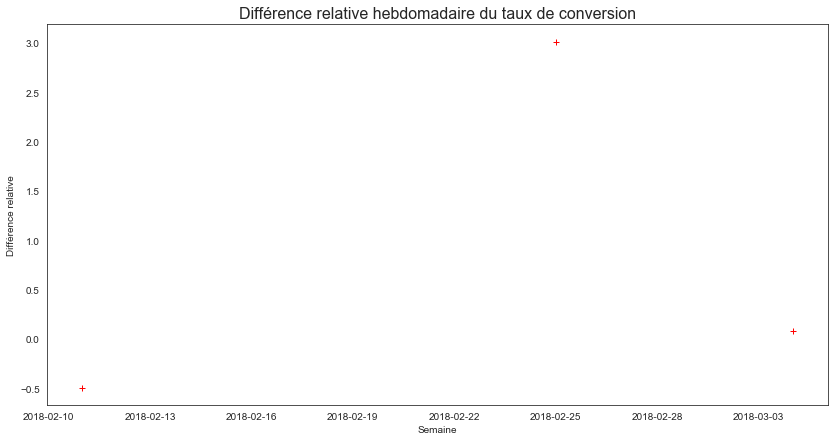

In [4]:
weekly_datasetA = datasetA.resample('W').sum()
weekly_datasetA['conv_rate'] = weekly_datasetA['n_convs'] / weekly_datasetA['total_impressions']

weekly_datasetB = datasetB.resample('W').sum()
weekly_datasetB['conv_rate'] = weekly_datasetB['n_convs'] / weekly_datasetB['total_impressions']

weekly_relative_difference = (weekly_datasetA - weekly_datasetB) / weekly_datasetB

plt.rcParams["figure.figsize"] = (14,7)
plt.plot(weekly_relative_difference.index, weekly_relative_difference['conv_rate'], 'r+')
plt.xlabel('Semaine')
plt.ylabel('Différence relative')
plt.title('Différence relative hebdomadaire du taux de conversion', fontsize=16)
plt.show()

Tout d'abord, on remarque l'absence de données pour la semaine du 18 février : cela tient au fait que sur cette semaine, la version B n'a enregistré aucune conversion, si bien que le calcul de la différence relative est impossible.

Néanmoins, pour les semaines où il y avait suffisamment de données pour calculer une différence relative, il apparaît que celle-ci était toujours positive vers la fin de la campagne, c'est-à-dire que **la version A suscitait un taux de conversion supérieur à celui engendré par la version B vers la fin de la campagne publicitaire**. Néanmoins, au début de la campagne, il semblerait que la version B ait été meilleure que la version A.

# Analyse des données de la campagne "visite panier" de l'annonceur 2

## Stationnarité des données

On s'intéresse dans un premier temps à la stationnarité des données : le taux de conversion dépend-t-il du jour de la visite ? Y a-t-il des jours où le taux de conversion semble influencer la conversion des utilisateurs ? Qu'en est-il après différenciation de la série temporelle au premier ordre ?

In [5]:
adf_test(datasetA['conv_rate'])

,Results of Augmented Dickey-Fuller test:
test statistic,-4.921045
p-value,0.000032
# of lags,0.000000
# of observations,33.000000
Critical Value (1%),-3.646135
Critical Value (5%),-2.954127
Critical Value (10%),-2.615968


In [6]:
adf_test(datasetB['conv_rate'])

,Results of Augmented Dickey-Fuller test:
test statistic,-5.287447
p-value,0.000006
# of lags,0.000000
# of observations,33.000000
Critical Value (1%),-3.646135
Critical Value (5%),-2.954127
Critical Value (10%),-2.615968


Un test de Dickey-Fuller sur la série temporelle des taux de conversions journaliers pour la version A indique que celle-ci est stationnaire (p-value inférieure à 1%). De même, la série temporelle pour la version B indique que celle-ci est stationnaire.

In [7]:
adf_test(list(np.diff(datasetA['conv_rate'])))

,Results of Augmented Dickey-Fuller test:
test statistic,-2.752607
p-value,0.065369
# of lags,8.000000
# of observations,24.000000
Critical Value (1%),-3.737709
Critical Value (5%),-2.992216
Critical Value (10%),-2.635747


In [8]:
adf_test(list(np.diff(datasetB['conv_rate'])))

,Results of Augmented Dickey-Fuller test:
test statistic,-6.499376e+00
p-value,1.172234e-08
# of lags,1.000000e+00
# of observations,3.100000e+01
Critical Value (1%),-3.661429e+00
Critical Value (5%),-2.960525e+00
Critical Value (10%),-2.619319e+00


On a toujours stationnarité de la série temporelle de la version B (à un seuil de 1%), en revanche, on n'a plus la stationnarité de la version A au seuil de 1%, mais on l'a toujours au seuil de 10%.

## Saisonnalité des données

On essaie ensuite de voir si de la série temporelle on peut dégager certaines tendances : tendance globale, composante saisonnière et résidu, le but étant de voir si les taux de conversion peuvent être affectés par certains cycles temporels, et, le cas échéant, dans quelle mesure. Puisque nous travaillons avec des taux de conversion dont les valeurs peuvent être nulles, on se focalisera essentiellement sur des modèles additifs.

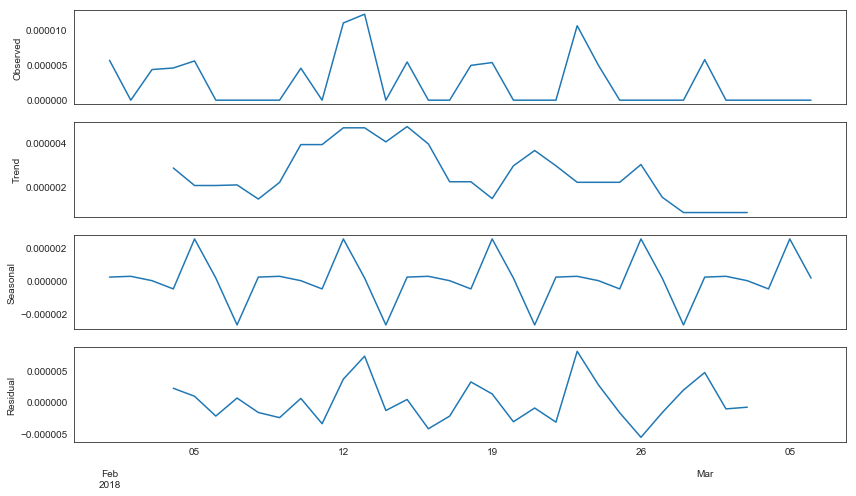

In [9]:
conversion_rate = datasetA['conv_rate']
conversion_rate.index = pd.to_datetime(conversion_rate.index)
decomposition = statsmodels.tsa.seasonal.seasonal_decompose(conversion_rate, model="additive")
plt.rcParams["figure.figsize"] = (12,7)
decomposition.plot()
plt.show()

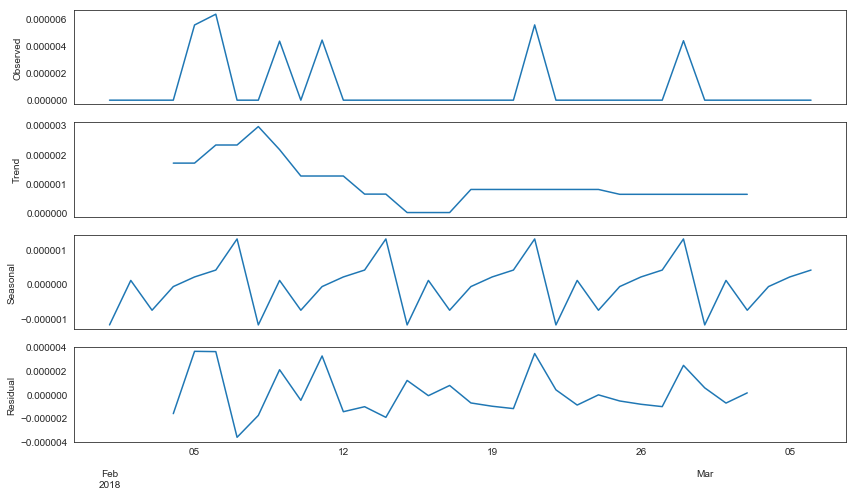

In [10]:
conversion_rate = datasetB['conv_rate']
conversion_rate.index = pd.to_datetime(conversion_rate.index)
decomposition = statsmodels.tsa.seasonal.seasonal_decompose(conversion_rate, model="additive")
plt.rcParams["figure.figsize"] = (12,7)
decomposition.plot()
plt.show()

# Z-test : conclusion quant à l'efficacité du test A/B mené

## Z-test global

Enfin, on conduit un Z-test destiné à mesure l'efficacité statistique du test A/B mené. Mathématiquement, cela se traduit par la comparaison de l'hypothèse nulle H0 : "le taux de conversion sous version A est le même que celui sous version B" avec l'hypothèse H1 : "le taux de conversion sous version A est différent que celui sous version B". En d'autres termes, l'hypothèse H1 traduit le fait que la version B a bel et bien une influence sur le taux de conversion.

In [11]:
from scipy.stats import norm
pA = sum(datasetA['n_convs']) / sum(datasetA['total_impressions'])
pB = sum(datasetB['n_convs']) / sum(datasetB['total_impressions'])

nA = sum(datasetA['total_impressions'])
nB = sum(datasetB['total_impressions'])

Z_value = (pA - pB) / np.sqrt(pA * (1 - pA) / nA + pB * (1 - pB) / nB)
p_val = 1 - norm.cdf(abs(Z_value)) + norm.cdf(-abs(Z_value))

print(p_val)

0.028943176324250502


On obtient une p-valeur inférieure aux seuils usuels de 10% et 5%. On rejette donc l'hypothèse H0 et on en déduit alors que **la version A semble avoir plus d'influence sur le taux de conversion que la version B. En effet, comme vu précédemment, les taux de conversion sous version A sont supérieurs à ceux sous la version B.**

## Z-test cumulé (pas journalier)

On s'intéresse maintenant aux **données cumulées** : en regardant l'ensemble des informations dont on dispose du jour 1 de la campagne publicitaire au jour n, peut-on voir une certaine tendance quant au test d'hypothèses ?

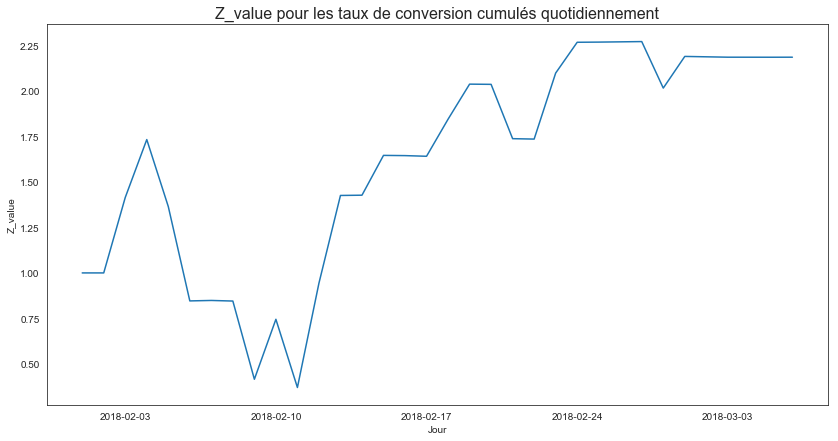

In [12]:
daily_cumsum_datasetA = datasetA[['total_impressions', 'n_convs']].cumsum()
daily_cumsum_datasetB = datasetB[['total_impressions', 'n_convs']].cumsum()
daily_cumsum_datasetA['conv_rate'] = daily_cumsum_datasetA['n_convs'] / daily_cumsum_datasetA['total_impressions']
daily_cumsum_datasetB['conv_rate'] = daily_cumsum_datasetB['n_convs'] / daily_cumsum_datasetB['total_impressions']

Z_value_1D = []
p_value_1D = []

for date in daily_cumsum_datasetA.index:
    pA = daily_cumsum_datasetA.loc[date]['conv_rate']
    nA = daily_cumsum_datasetA.loc[date]['total_impressions']
    pB = daily_cumsum_datasetB.loc[date]['conv_rate']
    nB = daily_cumsum_datasetB.loc[date]['total_impressions']
    Z_value_1D.append((pA-pB)/np.sqrt(pA*(1-pA)/nA + pB*(1-pB)/nB))
    p_value_1D.append(1 - norm.cdf(abs(Z_value_1D[-1])) + norm.cdf(-abs(Z_value_1D[-1])))

        
plt.rcParams["figure.figsize"] = (14,7)
plt.plot(daily_cumsum_datasetA.index, Z_value_1D)
plt.xlabel('Jour')
plt.ylabel('Z_value')
plt.title('Z_value pour les taux de conversion cumulés quotidiennement', fontsize=16)
plt.show()

La Z-value est toujours positive. Cette valeur était du signe de la différence entre le taux de conversion sous version A et celui sous version B, cela nous indique qu'a priori, la version A était meilleure que la version B. Il reste à voir si cela peut être confirmé ou infirmé statistiquement. On s'intéresse ainsi à l'évoluation de la p-valeur.

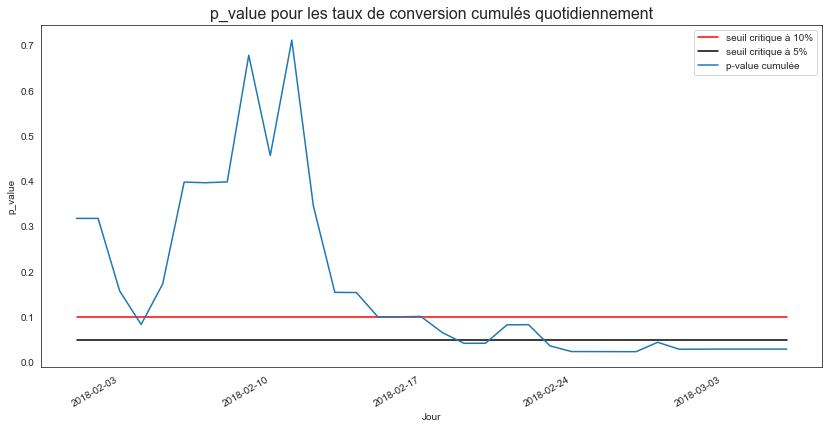

In [13]:
plt.rcParams["figure.figsize"] = (14,7)

fig, ax = plt.subplots()
fig.autofmt_xdate()
ax.plot_date(datasetA.index, [0.1]*len(datasetA.index), marker='', linestyle='-', c='red')
ax.plot_date(datasetA.index, [0.05]*len(datasetA.index), marker='', linestyle='-', c='black')
plt.plot(daily_cumsum_datasetA.index, p_value_1D)
plt.xlabel('Jour')
plt.ylabel('p_value')
plt.title('p_value pour les taux de conversion cumulés quotidiennement', fontsize=16)
plt.legend(['seuil critique à 10%', 'seuil critique à 5%', 'p-value cumulée'], loc='best')
plt.show()

On voit ainsi que la p-value cumulée se situe au-delà du seuil critique à 10% jusqu'au 15 février 2018 environ, soit approximativement le milieu de la campagne. En d'autres termes, l'hypothèse nulle "la version B n'a pas plus d'influence que la version A sur le taux de conversion" aurait été acceptée si la campagne avait pris fin avant le 15 février. Néanmoins, en prenant une vue globale de la campagne après cette date, on s'aperçoit qu'il convient finalement de rejeter l'hypothèse nulle, et d'en déduire que la version A est en réalité meilleure que la version B. **Cela tient notamment au fait que la version A a enregistré un grand nombre de conversions la semaine du 15 février, contrairement à la version B qui n'en a enregistré aucune**, changeant ainsi significativement la p-value.

Par ailleurs, on notera que la p-valeur descend légèrement sous les 10% le jour du 4 février. Si la campagne avait pris fin ce jour-là, on en aura déduit que la version A était meilleure que la B, mais cela n'aurait sans doute été recevable dans la mesure où la campagne aurait été menée sur une durée inférieure à une semaine. Avec une fenêtre temporelle plus large, on s'aperçoit que cette hypothèse est finalement valide.

Avec une significativité à 5%, la ligne rouge aurait été à 0,05. La courbe bleue représentant la p-value cumulée serait passée en-deçà de ce seuil critique à la date du 22 février, et y serait restée jusqu'à la fin de la campagne. Autrement dit, **si l'on s'était fixé un seuil de confiance à 5% pour accepter l'hypothèse selon laquelle la version A était meilleure que la version B, cette hypothèse aurait été acceptée à la date du 22 février**, contrairement au seuil de confiance de 10% qui nous aurait fait admettre la conclusion le 15 février.


Comme pour le seuil à 10%, on observe une légère descente de la p-value sous le seuil des 5% les 18 et 19 février, avant de remonter au-dessus de ce seuil : on avait suffisamment de significativité pour décréter que la version A était meilleure que la version B ces deux jours. Cette conclusion n'aurait pas tenu pour les trois jours qui suivaient, mais aurait été valable à partir du 22 février, et ce jusqu'à la fin de la campagne.

## Z-test cumulé (pas de 3 jours)

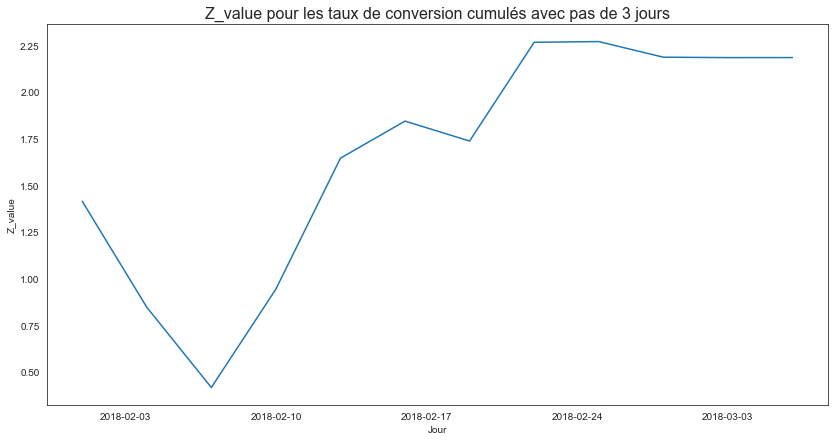

In [14]:
def cumulated_dataset_freq(dataset, frequency):  # dataset cumulé avec un pas de frequency jours
    cumulated_dataset = dataset.resample(frequency).sum().cumsum()
    cumulated_dataset['conv_rate'] = cumulated_dataset['n_convs'] / cumulated_dataset['total_impressions']
    return cumulated_dataset

frequency = '3D'

cumulated_datasetA = cumulated_dataset_freq(datasetA, frequency)
cumulated_datasetB = cumulated_dataset_freq(datasetB, frequency)

Z_value_3D = []
p_value_3D = []

for date in cumulated_datasetA.index:
    pA = cumulated_datasetA.loc[date]['conv_rate']
    nA = cumulated_datasetA.loc[date]['total_impressions']
    pB = cumulated_datasetB.loc[date]['conv_rate']
    nB = cumulated_datasetB.loc[date]['total_impressions']
    Z_value_3D.append((pA-pB)/np.sqrt(pA*(1-pA)/nA + pB*(1-pB)/nB))
    p_value_3D.append(1 - norm.cdf(abs(Z_value_3D[-1])) + norm.cdf(-abs(Z_value_3D[-1])))
    
plt.rcParams["figure.figsize"] = (14,7)
plt.plot(cumulated_datasetA.index, Z_value_3D)
plt.xlabel('Jour')
plt.ylabel('Z_value')
plt.title(f'Z_value pour les taux de conversion cumulés avec pas de {frequency[0]} jours', fontsize=16)
plt.show()

L'évolution de la Z-value est ainsi similaire à celle trouvée avec un pas quotidien. En effet, en prenant une fenêtre temporelle plus large pour regarder le cumul des données, on obtient une courbe plus lissée car celle-ci agrège les données à un plus haut niveau. L'allure reste toutefois semblable à celle où la fenêtre est plus réduite (et donc plus précise). Intéressons maintenant l'évolution de la p-value : **une fenêtre temporelle de 3 jours pour le cumul des données change-t-il la significativité du test, et donc la conclusion finale ?**

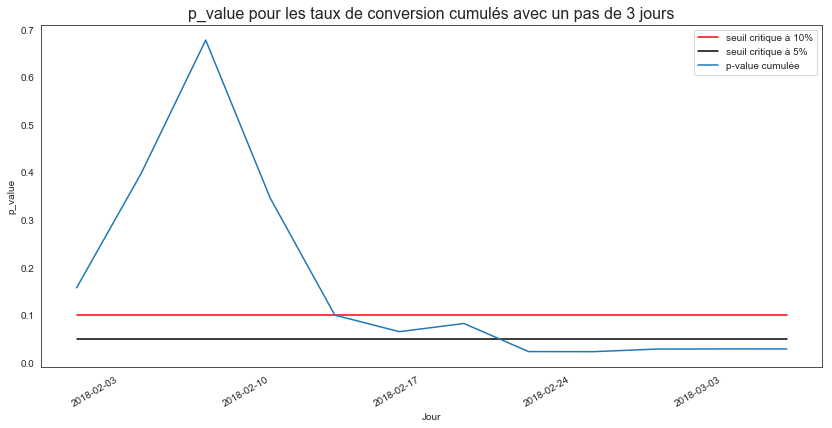

In [15]:
plt.rcParams["figure.figsize"] = (14,7)

fig, ax = plt.subplots()
fig.autofmt_xdate()
ax.plot_date(cumulated_datasetA.index, [0.1]*len(cumulated_datasetA.index), marker='', linestyle='-', c='red')
ax.plot_date(cumulated_datasetA.index, [0.05]*len(cumulated_datasetA.index), marker='', linestyle='-', c='black')
plt.plot(cumulated_datasetA.index, p_value_3D)
plt.xlabel('Jour')
plt.ylabel('p_value')
plt.title(f'p_value pour les taux de conversion cumulés avec un pas de {frequency[0]} jours', fontsize=16)
plt.legend(['seuil critique à 10%', 'seuil critique à 5%', 'p-value cumulée'], loc='best')
plt.show()

Là encore, la p-value cumulée se comporte de manière similaire : hausse jusqu'au 7 février puis chute jusqu'à la fin de la campagne. En revanche, un niveau d'agrégation des données de 3 jours change légèrement la date à laquelle les conclusions sont significativement recevables. En effet, pour le seuil critique à 10%, on peut affirmer dès le 13 février que la version A est meilleure que la version B. Pour le seuil critique à 5%, on peut l'affirmer dès le 20 février. Ainsi, **avec un regroupement des données par "paquets" de 3 jours, on peut établir que la version A est meilleure que la version B en moyenne une semaine plus tôt que si les données étaient observées quotidiennement**.


De plus, la significativité ne change pas : la p-value reste toujours en-deçà du seuil à 10% après le 13 février, et toujours sous le seuil à 5% après le 20 février. En d'autres termes, regarder les données tous les 3 jours permet de ne pas s'attarder sur des sauts de significativité dus à des taux de conversion élevés pour un seul jour, et permet de "diluer" l'effet de ces taux élevés.

# Modèles ARMA pour prédiction de la Z-value et p-value

### Z-valeur

In [18]:
Z_cum = pd.Series(Z_value_1D)
Z_cum.index = daily_cumsum_datasetA.index
series = Z_cum

def arma_model_selection_stationary(series, max_ar=4, max_ma=4):
    assert not series.isnull().any()
    order_select = sto.arma_order_select_ic(
        Z_cum.values,
        ic=['aic', 'bic'],
        max_ar=max_ar,
        max_ma=max_ma
    )
    
    ### AIC ###
    order_aic = order_select['aic'].values
    list_aic = [order_select['aic'][i][j] for j in range(0, max_ar+1) for i in range(0, max_ma+1)]
    list_order_aic = [(j,i) for j in range(0,max_ar+1) for i in range(0, max_ma+1)]
    
    list_order_aic = [x for _,x in sorted(zip(list_aic,list_order_aic))]
    list_aic.sort()
    
    order_aic_stationary = None
    
    for order_aic in list_order_aic:
        try:
            ARIMA(series.values, order=(order_aic[0], 0, order_aic[1])).fit()
            order_aic_stationary = order_aic
            break
        except Exception as e:
            if isinstance(e, ValueError):
                pass
    
    aic_stationary = list_aic[list_order_aic.index(order_aic_stationary)]
    
    ### BIC ###
    order_bic = order_select['bic'].values
    list_bic = [order_select['bic'][i][j] for j in range(0, max_ar+1) for i in range(0, max_ma+1)]
    list_order_bic = [(j,i) for j in range(0,max_ar+1) for i in range(0, max_ma+1)]
    
    list_order_bic = [x for _,x in sorted(zip(list_bic,list_order_bic))]
    list_bic.sort()
    
    order_bic_stationary = None
    
    for order_bic in list_order_bic:
        try:
            ARIMA(series.values, order=(order_bic[0], 0, order_bic[1])).fit()
            order_bic_stationary = order_bic
            break
        except Exception as e:
            if isinstance(e, ValueError):
                pass
    
    bic_stationary = list_bic[list_order_bic.index(order_bic_stationary)]
    
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    sns.heatmap(order_select["aic"])
    plt.xlabel("Ordre MA")
    plt.ylabel("Ordre AR")
    plt.title("Résultats AIC")

    plt.subplot(1, 2, 2)
    sns.heatmap(order_select["bic"])
    plt.xlabel("Ordre MA")
    plt.ylabel("Ordre AR")
    plt.title("Résultats BIC")

    plt.suptitle(f"max_ar={max_ar}, max_ma={max_ma}")
    plt.show();

    print(
        "AIC meilleur modèle stationnaire : AR={}, MA={}, AIC={} ".format(
            order_aic_stationary[0], order_aic_stationary[1],
            aic_stationary
        )
    )
    print(
        "BIC meilleur modèle stationnaire : AR={}, MA={}, BIC={} ".format(
            order_bic_stationary[0], order_bic_stationary[1],
            bic_stationary
        )
    )

    return order_aic_stationary, order_bic_stationary

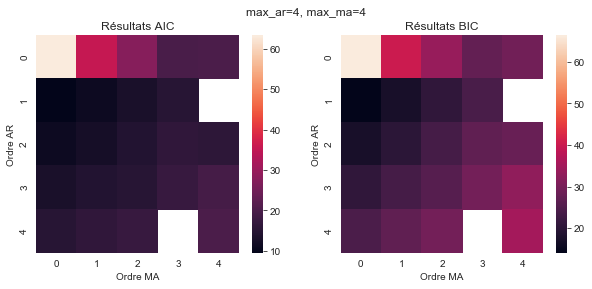

AIC meilleur modèle stationnaire : AR=1, MA=0, AIC=9.517292310173943 
BIC meilleur modèle stationnaire : AR=1, MA=0, BIC=14.096373884022427 


In [20]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

##################################### PARAMETRES #####################################
max_ar = 4
max_ma = 4
######################################################################################

order_select = sto.arma_order_select_ic(
    series.values,
    ic = ['aic', 'bic'],
    max_ar=max_ar, 
    max_ma=max_ma
)

aic_min_order, bic_min_order = arma_model_selection_stationary(series, max_ar=max_ar, max_ma=max_ma)

Les deux critères AIC et BIC suggèrent un modèle AR(1).

# Meilleur modèle selon AIC

## Fit du modèle



                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   34
Model:                     ARMA(1, 0)   Log Likelihood                  -1.759
Method:                       css-mle   S.D. of innovations              0.249
Date:                Thu, 21 Feb 2019   AIC                              9.517
Time:                        21:05:01   BIC                             14.096
Sample:                             0   HQIC                            11.079
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6084      0.357      4.509      0.000       0.909       2.307
ar.L1.y        0.9042      0.066     13.600      0.000       0.774       1.034
                                    Roots         

## Erreurs

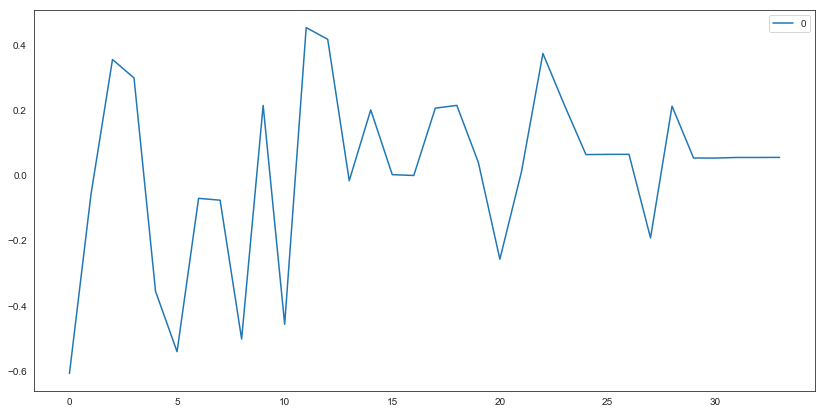

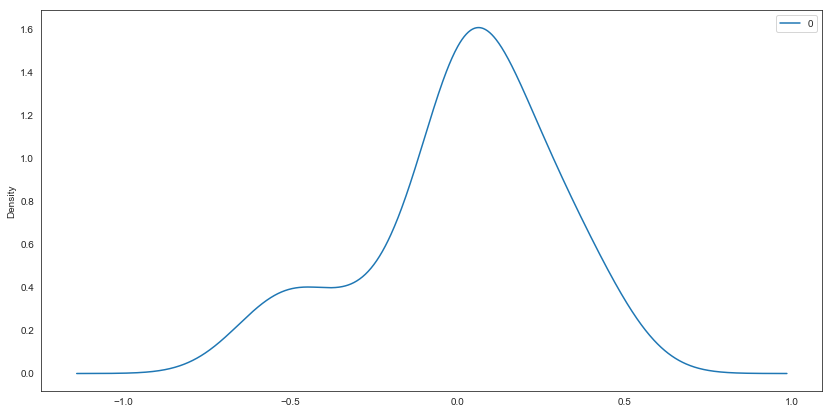

               0
count  34.000000
mean    0.016179
std     0.269320
min    -0.608373
25%    -0.067470
50%     0.054269
75%     0.211198
max     0.454006


# Meilleur modèle selon BIC

## Fit du modèle



                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   34
Model:                     ARMA(1, 0)   Log Likelihood                  -1.759
Method:                       css-mle   S.D. of innovations              0.249
Date:                Thu, 21 Feb 2019   AIC                              9.517
Time:                        21:05:01   BIC                             14.096
Sample:                             0   HQIC                            11.079
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6084      0.357      4.509      0.000       0.909       2.307
ar.L1.y        0.9042      0.066     13.600      0.000       0.774       1.034
                                    Roots         

## Erreurs

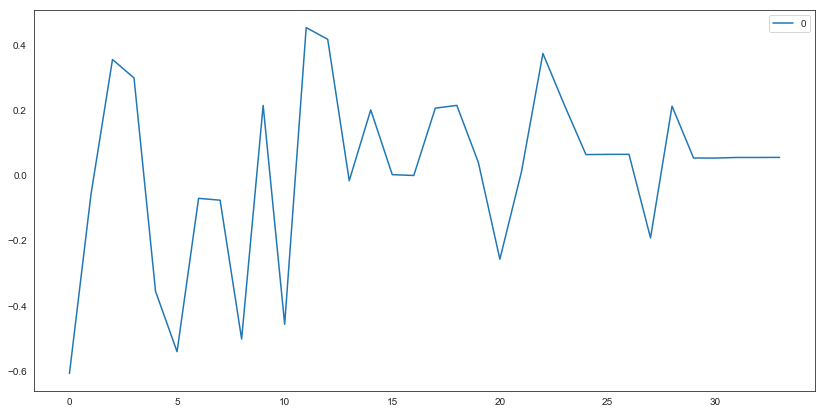

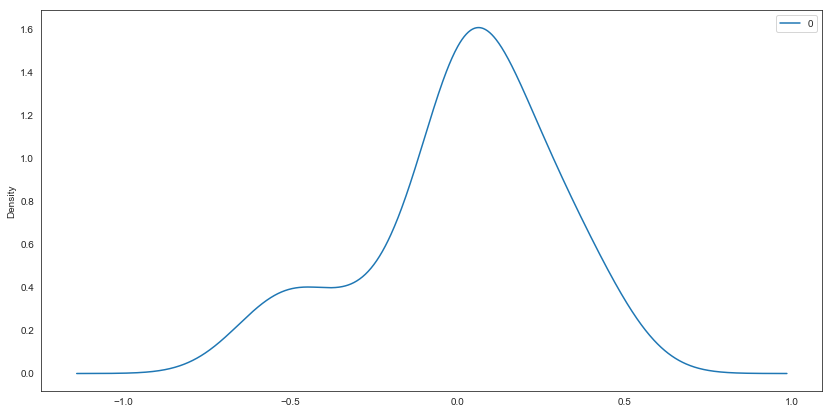

               0
count  34.000000
mean    0.016179
std     0.269320
min    -0.608373
25%    -0.067470
50%     0.054269
75%     0.211198
max     0.454006


In [21]:
display(Markdown("# Meilleur modèle selon AIC"))
testARMA(Z_cum.values, p=aic_min_order[0], d=0, q=aic_min_order[1])

display(Markdown("# Meilleur modèle selon BIC"))
testARMA(Z_cum.values, p=bic_min_order[0], d=0, q=bic_min_order[1])

### p-valeur

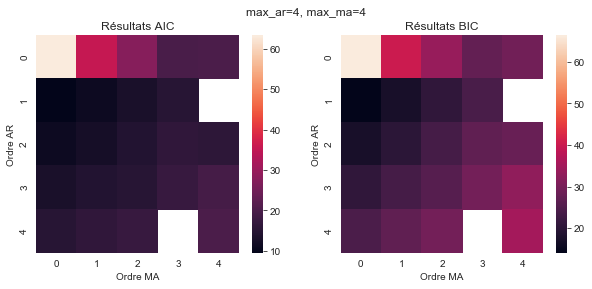

AIC meilleur modèle stationnaire : AR=1, MA=0, AIC=9.517292310173943 
BIC meilleur modèle stationnaire : AR=1, MA=0, BIC=14.096373884022427 


In [22]:
P_rej = pd.Series(p_value_1D)
P_rej.index = daily_cumsum_datasetA.index
series = P_rej

##################################### PARAMETRES #####################################
max_ar = 4
max_ma = 4
######################################################################################

order_select = sto.arma_order_select_ic(
    series.values,
    ic = ['aic', 'bic'],
    max_ar=max_ar, 
    max_ma=max_ma
)

aic_min_order, bic_min_order = arma_model_selection_stationary(P_rej, max_ar=max_ar, max_ma=max_ma)

Pour la p-valeur, les critères AIC et BIC suggèrent un modèle AR(1) aussi.

# Meilleur modèle selon AIC

## Fit du modèle



                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   34
Model:                     ARMA(1, 0)   Log Likelihood                  25.837
Method:                       css-mle   S.D. of innovations              0.112
Date:                Thu, 21 Feb 2019   AIC                            -45.673
Time:                        21:07:56   BIC                            -41.094
Sample:                             0   HQIC                           -44.112
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1686      0.083      2.021      0.052       0.005       0.332
ar.L1.y        0.7928      0.098      8.051      0.000       0.600       0.986
                                    Roots         

## Erreurs

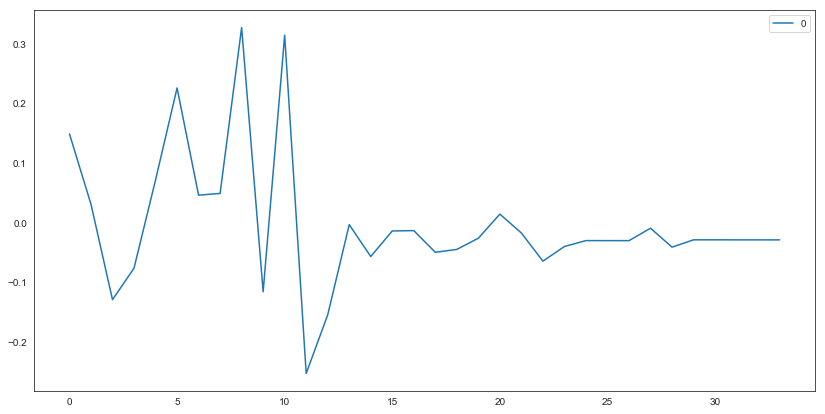

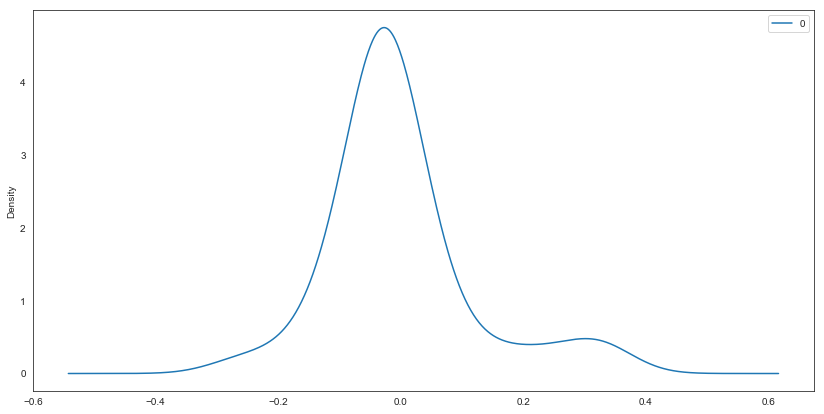

               0
count  34.000000
mean   -0.003468
std     0.115006
min    -0.252934
25%    -0.043971
50%    -0.028889
75%     0.009861
max     0.326951


# Meilleur modèle selon BIC

## Fit du modèle



                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   34
Model:                     ARMA(1, 0)   Log Likelihood                  25.837
Method:                       css-mle   S.D. of innovations              0.112
Date:                Thu, 21 Feb 2019   AIC                            -45.673
Time:                        21:07:56   BIC                            -41.094
Sample:                             0   HQIC                           -44.112
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1686      0.083      2.021      0.052       0.005       0.332
ar.L1.y        0.7928      0.098      8.051      0.000       0.600       0.986
                                    Roots         

## Erreurs

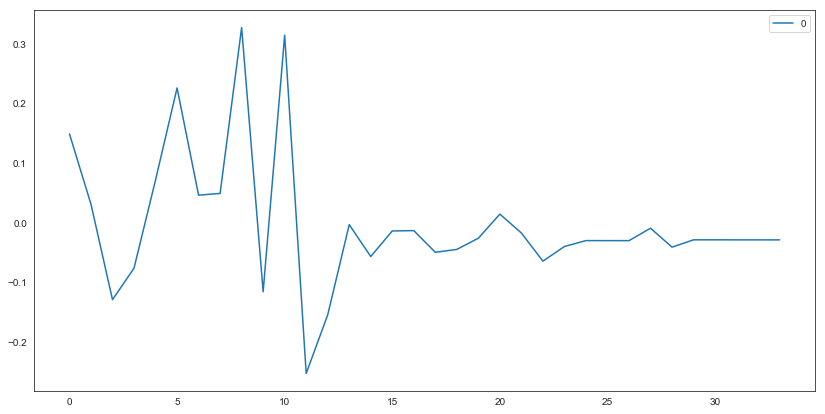

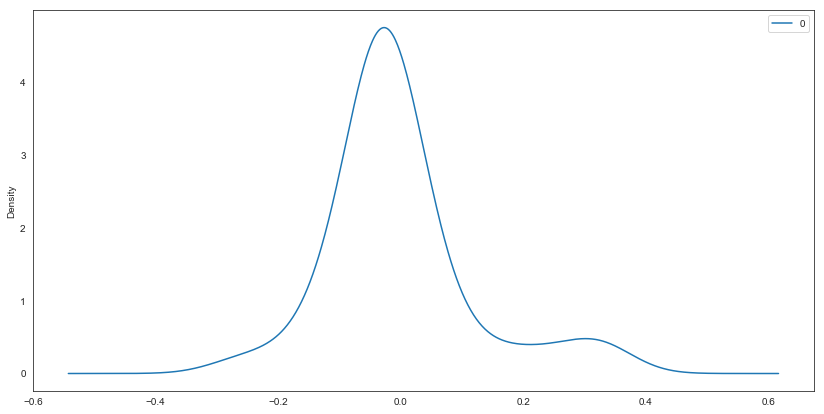

               0
count  34.000000
mean   -0.003468
std     0.115006
min    -0.252934
25%    -0.043971
50%    -0.028889
75%     0.009861
max     0.326951


In [23]:
display(Markdown("# Meilleur modèle selon AIC"))
testARMA(P_rej.values, p=aic_min_order[0], d=0, q=aic_min_order[1])

display(Markdown("# Meilleur modèle selon BIC"))
testARMA(P_rej.values, p=bic_min_order[0], d=0, q=bic_min_order[1])

# Prédictions sur les données empiriques pour arrêt de test anticipé

L'idée est ici de tronquer la série chronologique de Z ou P à un instant t avant la fin de la campagne et de lui faire correspondre un modèle dans le but de savoir s'il est possible d'arrêter le test avant. (question budgétaire)

### train ratio de 0.5

In [24]:
train_ratio = 0.5
t = round(train_ratio*len(Z_cum))
Z_tronq = Z_cum[:t]
P_tronq = P_rej[:t]

#### Z-value

Z_tronq


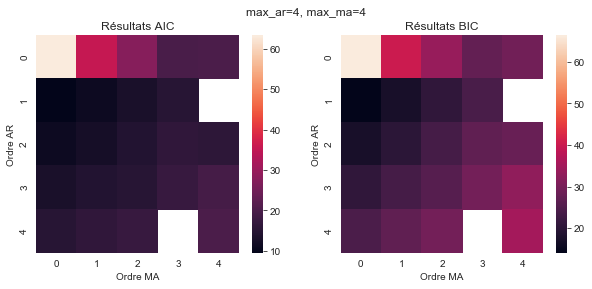

AIC meilleur modèle stationnaire : AR=1, MA=0, AIC=9.517292310173943 
BIC meilleur modèle stationnaire : AR=1, MA=0, BIC=14.096373884022427 


In [25]:
series = Z_tronq

print("Z_tronq")

##################################### PARAMETRES #####################################
max_ar = 4
max_ma = 4
######################################################################################

order_select = sto.arma_order_select_ic(
    Z_tronq.values,
    ic = ['aic', 'bic'],
    max_ar=max_ar, 
    max_ma=max_ma
)

aic_min_order, bic_min_order = arma_model_selection_stationary(series, max_ar=max_ar, max_ma=max_ma)

## MSE Best Model



Attention,  0  journées avec NaN
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   17
Model:                     ARMA(4, 3)   Log Likelihood                   0.401
Method:                       css-mle   S.D. of innovations              0.187
Date:                Thu, 21 Feb 2019   AIC                             17.198
Time:                        21:12:55   BIC                             24.697
Sample:                    02-01-2018   HQIC                            17.943
                         - 02-17-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0293      0.066     15.522      0.000       0.899       1.159
ar.L1.y        0.8151      0.272      2.999      0.015       0.282       1.348
ar.L2.y        0.

## Erreurs

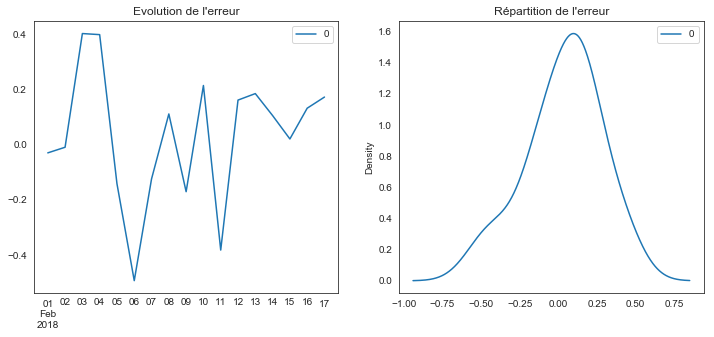

In [26]:
def arma_select_mse(y,max_ar = 2,max_ma=2,d = 0):
    MSE = np.zeros((max_ar +1,max_ma +1) )
    for p in range(max_ar + 1):
        for q in range(max_ma + 1):
            try :
                md = ARIMA(y, order=(p, d, q)).fit()
                MSE[p,q] = sum(np.array(md.resid)**2)
            except:
                MSE[p,q] = float('Inf')
                continue  #not raising exceptions if non invertible or non causal models
            
    mse_min_order = np.nanargmin(MSE)//MSE.shape[1], np.nanargmin(MSE)%MSE.shape[1] 
    return mse_min_order

mse_min_order = arma_select_mse(Z_tronq.values,max_ar=4,max_ma=4)
display(Markdown("## MSE Best Model"))
print('\n')

d = 0
p, q = mse_min_order[0], mse_min_order[1]
######################################################################################

print("Attention, ", Z_tronq.asfreq("D").isna().sum(), " journées avec NaN")

model_z_t = ARIMA(Z_tronq.asfreq("D").fillna(method="ffill"), order=(p, d, q), freq="D").fit()
# model_fit = model.fit(disp=0)
print(model_z_t.summary())
# print(model_fit.summary())
display(Markdown("## Erreurs"))
print('\n')
residuals = DataFrame(model_z_t.resid)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
residuals.plot(ax=plt.gca())
plt.title("Evolution de l'erreur")

plt.subplot(1, 2, 2)
residuals.plot(kind='kde', ax=plt.gca())
plt.title("Répartition de l'erreur")

plt.show()


## AIC Best Model



Attention,  0  journées avec NaN
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   17
Model:                     ARMA(1, 0)   Log Likelihood                  -3.971
Method:                       css-mle   S.D. of innovations              0.300
Date:                Thu, 21 Feb 2019   AIC                             13.941
Time:                        21:13:15   BIC                             16.441
Sample:                    02-01-2018   HQIC                            14.190
                         - 02-17-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1745      0.212      5.543      0.000       0.759       1.590
ar.L1.y        0.6930      0.167      4.145      0.001       0.365       1.021
                 

## Erreurs

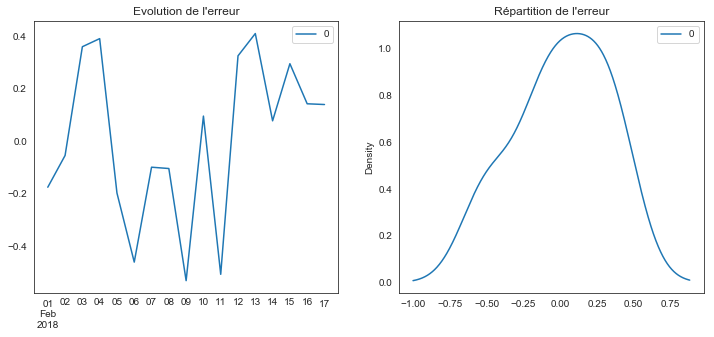

In [27]:
##################################### PARAMETRES #####################################
d = 0

display(Markdown("## AIC Best Model"))
print('\n')
p, q = aic_min_order[0], aic_min_order[1]
######################################################################################

# asfreq permettra de faire des predictions et de les afficher facilement...
# ffill au cas ou il manque des jours... 
# mais faire très attention aux datasets où il manque une grosse plage de journées!
# genre a1c1 vers la fin... donc je mets une limite au nb max de jours manquants
print("Attention, ", Z_tronq.asfreq("D").isna().sum(), " journées avec NaN")

model_z_t = ARIMA(Z_tronq.asfreq("D").fillna(method="ffill"), order=(p, d, q), freq="D").fit()
# model_fit = model.fit(disp=0)
print(model_z_t.summary())
# print(model_fit.summary())
display(Markdown("## Erreurs"))
print('\n')
residuals = DataFrame(model_z_t.resid)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
residuals.plot(ax=plt.gca())
plt.title("Evolution de l'erreur")

plt.subplot(1, 2, 2)
residuals.plot(kind='kde', ax=plt.gca())
plt.title("Répartition de l'erreur")

plt.show()

## BIC Best Model



Attention,  0  journées avec NaN
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   17
Model:                     ARMA(1, 0)   Log Likelihood                  -3.971
Method:                       css-mle   S.D. of innovations              0.300
Date:                Thu, 21 Feb 2019   AIC                             13.941
Time:                        21:13:23   BIC                             16.441
Sample:                    02-01-2018   HQIC                            14.190
                         - 02-17-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1745      0.212      5.543      0.000       0.759       1.590
ar.L1.y        0.6930      0.167      4.145      0.001       0.365       1.021
                 

## Erreurs

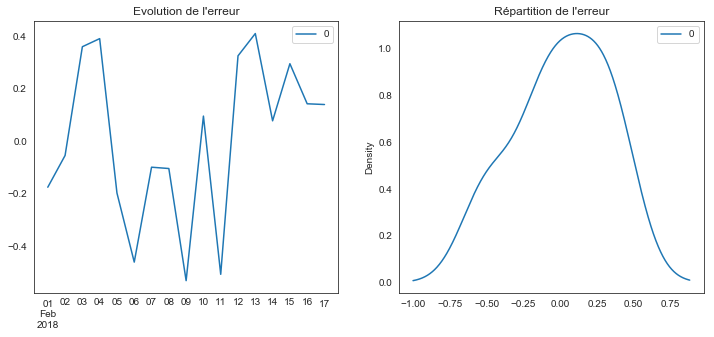

In [28]:
##################################### PARAMETRES #####################################
d = 0

display(Markdown("## BIC Best Model"))
print('\n')
p, q = bic_min_order[0], bic_min_order[1]
######################################################################################

# asfreq permettra de faire des predictions et de les afficher facilement...
# ffill au cas ou il manque des jours... 
# mais faire très attention aux datasets où il manque une grosse plage de journées!
# genre a1c1 vers la fin... donc je mets une limite au nb max de jours manquants
print("Attention, ", Z_tronq.asfreq("D").isna().sum(), " journées avec NaN")

model_z_t = ARIMA(Z_tronq.asfreq("D").fillna(method="ffill"), order=(p, d, q), freq="D").fit()
# model_fit = model.fit(disp=0)
print(model_z_t.summary())
# print(model_fit.summary())
display(Markdown("## Erreurs"))
print('\n')
residuals = DataFrame(model_z_t.resid)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
residuals.plot(ax=plt.gca())
plt.title("Evolution de l'erreur")

plt.subplot(1, 2, 2)
residuals.plot(kind='kde', ax=plt.gca())
plt.title("Répartition de l'erreur")

plt.show()

MSE best model : (4, 3)
AIC best model : (1, 0)
BIC best model : (1, 0)


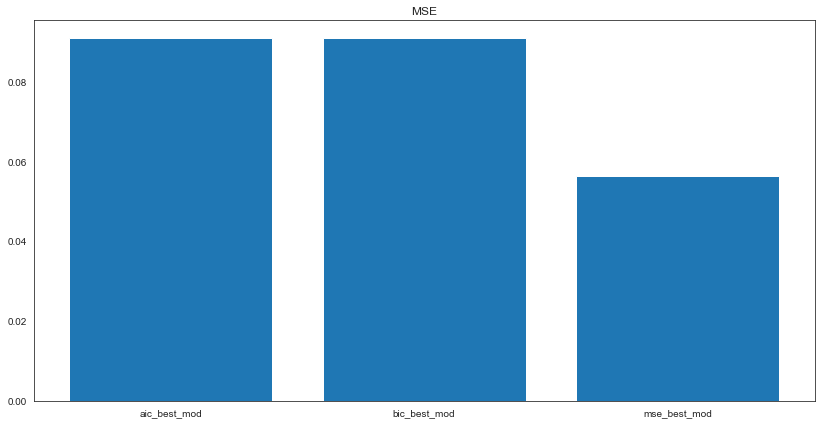

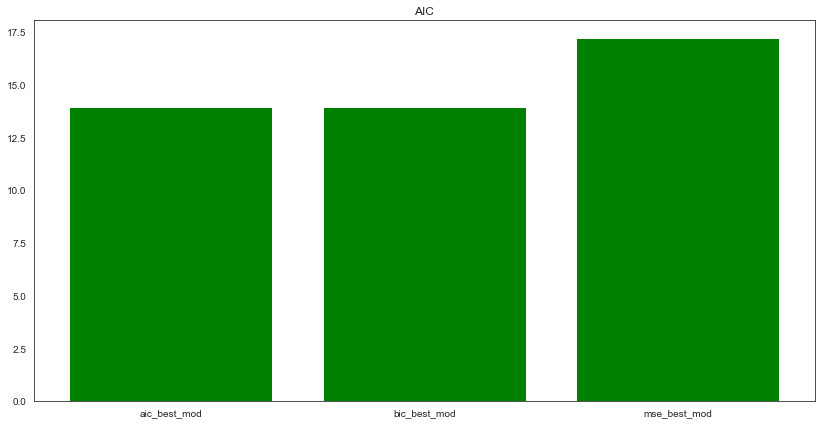

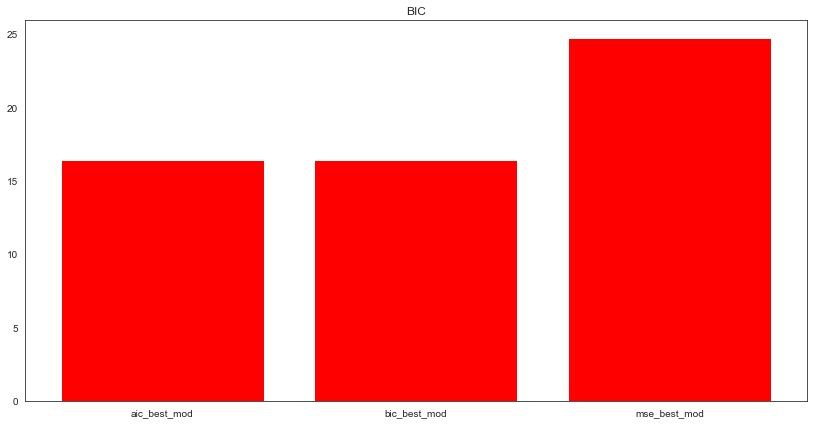

([0.0907431470098213, 0.0907431470098213, 0.0561953376715656],
 [13.941095671857077, 13.941095671857077, 17.198024213436028],
 [16.440735704025727, 16.440735704025727, 24.696944309941973])

In [29]:
comparaison_model(aic_min_order,bic_min_order,mse_min_order,Z_tronq)

On voit que la minimisation par AIC et par BIC conduisent à choisir un modèle AR(1). Le critère MSE suggère quant à lui un modèle ARMA(4,3).

#### p-valeur

P_tronq


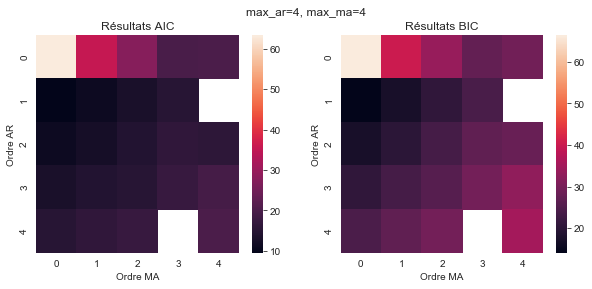

AIC meilleur modèle stationnaire : AR=1, MA=0, AIC=9.517292310173943 
BIC meilleur modèle stationnaire : AR=1, MA=0, BIC=14.096373884022427 


In [30]:
series = P_tronq

print("P_tronq")

##################################### PARAMETRES #####################################
max_ar = 4
max_ma = 4
######################################################################################

order_select = sto.arma_order_select_ic(
    series.values,
    ic = ['aic', 'bic'],
    max_ar=max_ar, 
    max_ma=max_ma
)

aic_min_order, bic_min_order = arma_model_selection_stationary(series, max_ar=max_ar, max_ma=max_ma)

## AIC and BIC Best Model



Attention,  0  journées avec NaN
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   17
Model:                     ARMA(1, 0)   Log Likelihood                   7.978
Method:                       css-mle   S.D. of innovations              0.149
Date:                Thu, 21 Feb 2019   AIC                             -9.956
Time:                        21:15:58   BIC                             -7.456
Sample:                    02-01-2018   HQIC                            -9.707
                         - 02-17-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2831      0.084      3.359      0.004       0.118       0.448
ar.L1.y        0.6019      0.186      3.239      0.006       0.238       0.966
                 

## Erreurs

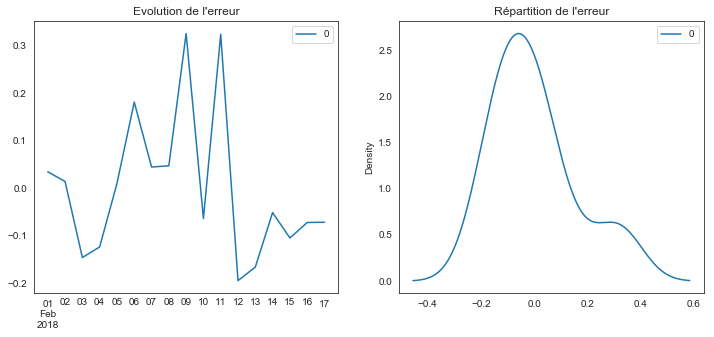

In [31]:
##################################### PARAMETRES #####################################
d = 0
display(Markdown("## AIC and BIC Best Model"))
print('\n')
p, q = 1, 0
######################################################################################

# asfreq permettra de faire des predictions et de les afficher facilement...
# ffill au cas ou il manque des jours... 
# mais faire très attention aux datasets où il manque une grosse plage de journées!
# genre a1c1 vers la fin... donc je mets une limite au nb max de jours manquants
print("Attention, ", P_tronq.asfreq("D").isna().sum(), " journées avec NaN")

model_p_t = ARIMA(P_tronq.asfreq("D").fillna(method="ffill"), order=(p, d, q), freq="D").fit()
# model_fit = model.fit(disp=0)
print(model_p_t.summary())
# print(model_fit.summary())
display(Markdown("## Erreurs"))
print('\n')
residuals = DataFrame(model_p_t.resid)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
residuals.plot(ax=plt.gca())
plt.title("Evolution de l'erreur")

plt.subplot(1, 2, 2)
residuals.plot(kind='kde', ax=plt.gca())
plt.title("Répartition de l'erreur")

plt.show()


## MSE Best Model



Attention,  0  journées avec NaN
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   17
Model:                     ARMA(4, 0)   Log Likelihood                  10.186
Method:                       css-mle   S.D. of innovations              0.127
Date:                Thu, 21 Feb 2019   AIC                             -8.371
Time:                        21:16:12   BIC                             -3.372
Sample:                    02-01-2018   HQIC                            -7.874
                         - 02-17-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3242      0.047      6.958      0.000       0.233       0.415
ar.L1.y        0.4363      0.211      2.070      0.061       0.023       0.849
ar.L2.y        0.

## Erreurs

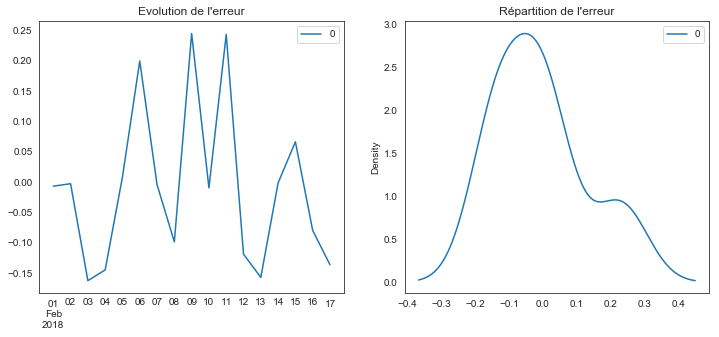

In [32]:
mse_min_order = arma_select_mse(P_tronq.values,max_ar=4,max_ma=4)
display(Markdown("## MSE Best Model"))
print('\n')

d = 0
p, q = mse_min_order[0], mse_min_order[1]
######################################################################################

print("Attention, ", P_tronq.asfreq("D").isna().sum(), " journées avec NaN")

model_z_t = ARIMA(P_tronq.asfreq("D").fillna(method="ffill"), order=(p, d, q), freq="D").fit()
# model_fit = model.fit(disp=0)
print(model_z_t.summary())
# print(model_fit.summary())
display(Markdown("## Erreurs"))
print('\n')
residuals = DataFrame(model_z_t.resid)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
residuals.plot(ax=plt.gca())
plt.title("Evolution de l'erreur")

plt.subplot(1, 2, 2)
residuals.plot(kind='kde', ax=plt.gca())
plt.title("Répartition de l'erreur")

plt.show()


MSE best model : (4, 0)
AIC best model : (1, 0)
BIC best model : (1, 0)


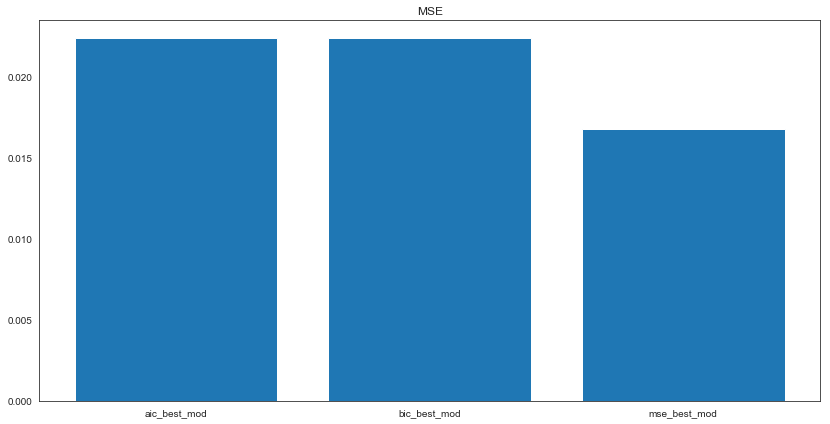

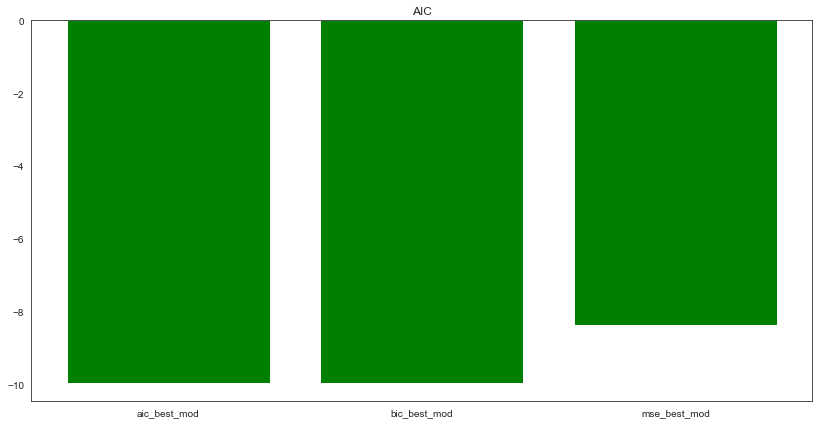

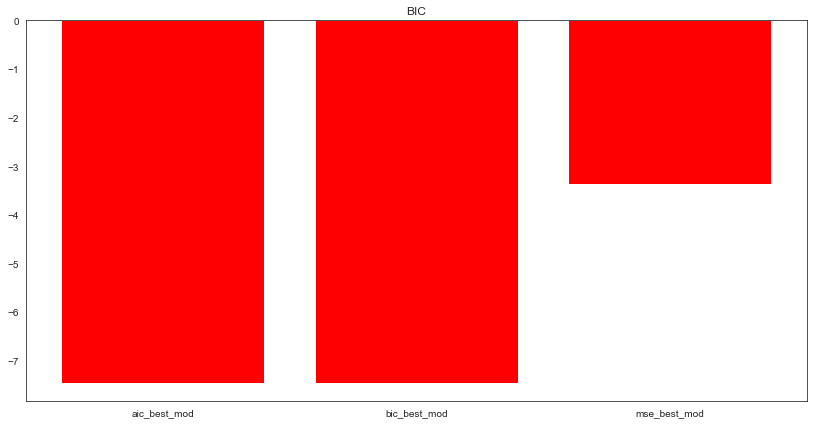

([0.022330670562142805, 0.022330670562142805, 0.016750143434354856],
 [-9.955727130470365, -9.955727130470365, -8.371232699746173],
 [-7.456087098301715, -7.456087098301715, -3.3719526354088742])

In [33]:
comparaison_model(aic_min_order,bic_min_order,mse_min_order,P_tronq)

A priori, les 3 modèles suggèrent un modèle ARMA avec uniquement une partie autorégressive. AIC et BIC donnent un modèle AR(1) tandis que MSE donne un modèle AR(4).

## Prédiction

Quelles sont les prévisions selon le modèle sur les données existantes (in-sample)? 
On réalise des prédictions de `pred_start` à `pred_end` (None donne la fin de la période)
On peut distinguer deux types de prévisions : 
+ 1-step-ahead : on utilise toutes les données jusqu'à J-1
+ Dynamic : à partir de pred_start on utilise les variables prédites comme entrées

In [35]:
def out_of_sample_prediction(p, q, y_true, train_ratio, signif=True, graph=True, alpha=0.05):
    t = round(train_ratio * len(y_true))
    train_data = y_true[:t]

    model = ARIMA(train_data, order=(p, 0, q)).fit()

    pred_start = t
    pred_end = len(y_true)

    pred_index = np.arange(pred_start + 1, pred_end + 1)
    
    forecast, stderr, conf_int = model.forecast(pred_end - pred_start, alpha=alpha)

    if graph == True:
        plt.figure(figsize=(16, 4))
        plt.plot(np.arange(1, t + 1), train_data, label="Observed (train)", marker="o", ms=4)
        plt.plot(pred_index, y_true[t:], label="Test period (truth)", marker="o", ms=4)
        plt.plot(pred_index, forecast, label="Dynamic pred", marker="o", ms=4)
        # plt.plot(pred_index, one_step_ahead_predictions, label="1-step pred", marker="o", ms=4)
      
        # Intervalle de confiance au seuil 1-alpha
        plt.fill_between(pred_index, conf_int[:, 0], conf_int[:, 1], color='blue', alpha=0.25)

        plt.legend()
        plt.title(f"[train_ratio={train_ratio}] Resultats de prédiction pour AR={p} MA={q}")
    
        if signif == True:
            for threshold in [0.2, 0.1]:
                threshold_series = pd.Series(np.full(len(y_true), threshold))
                plt.plot(threshold_series, label=f"threshold={threshold}")
                # combien de fois on dépasse le seuil?
                print('Dépassement de la vraie série du seuil ( = significatif) à',threshold)
                print(sum(y_true[t:]<threshold))
                print('Dépassement de la prédiction dynamique du seuil ( = significatif) à',threshold)
                print(sum(forecast<threshold))
                plt.legend()
        plt.show()
    return forecast, conf_int

#### a. Z_valeur

out_of_sample_prediction of Z_cum with 95% Confidence Interval, train_ratio= 0.25


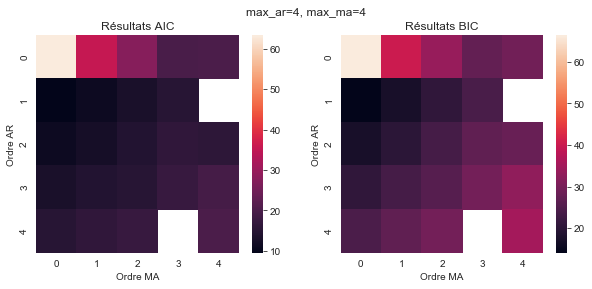

AIC meilleur modèle stationnaire : AR=1, MA=0, AIC=9.517292310173943 
BIC meilleur modèle stationnaire : AR=1, MA=0, BIC=14.096373884022427 


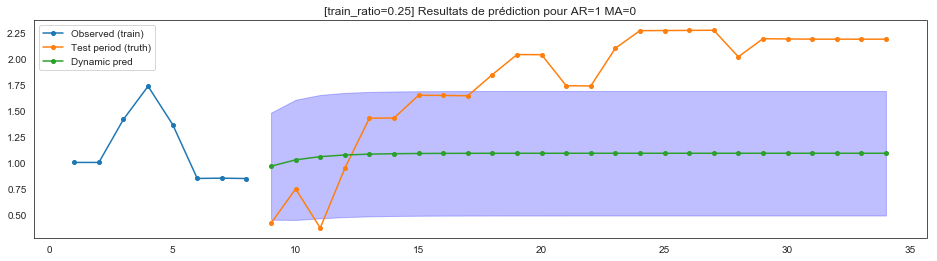

out_of_sample_prediction of Z_cum with 95% Confidence Interval, train_ratio= 0.5


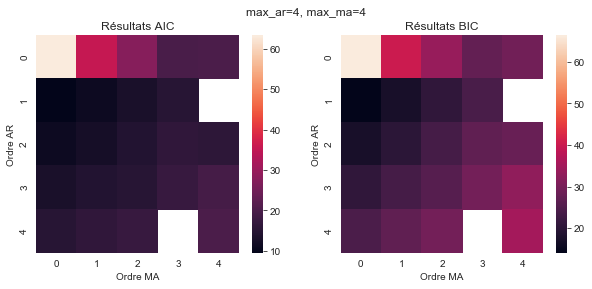

AIC meilleur modèle stationnaire : AR=1, MA=0, AIC=9.517292310173943 
BIC meilleur modèle stationnaire : AR=1, MA=0, BIC=14.096373884022427 


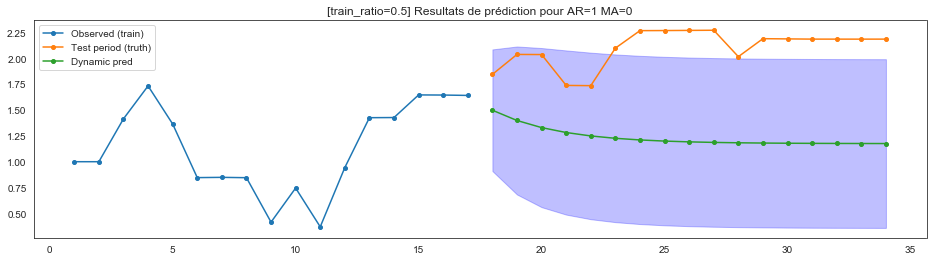

out_of_sample_prediction of Z_cum with 95% Confidence Interval, train_ratio= 0.65


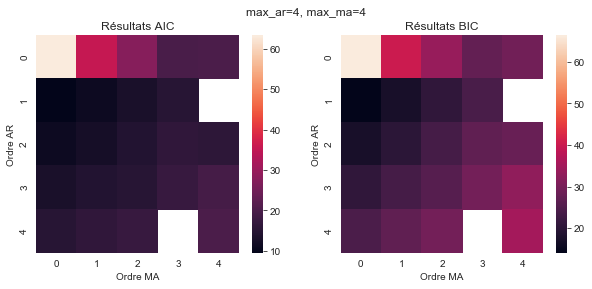

AIC meilleur modèle stationnaire : AR=1, MA=0, AIC=9.517292310173943 
BIC meilleur modèle stationnaire : AR=1, MA=0, BIC=14.096373884022427 


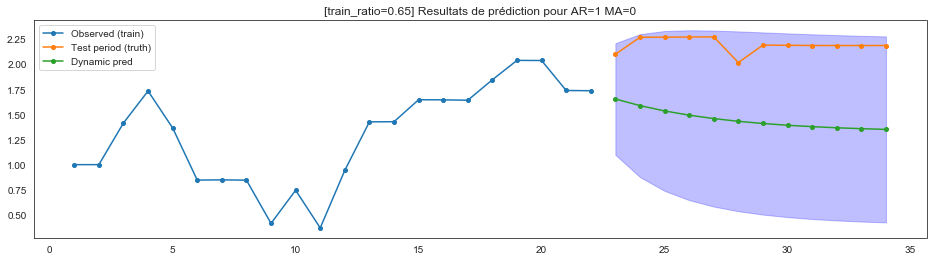

In [36]:
##################################### PARAMETRES #####################################
pred_start = 45  # debut des predictions
pred_end = 100  # fin des predictions
pred_start = 15
pred_end = None
######################################################################################
train_ratio_list = [0.25,0.5,0.65]
for train_ratio in train_ratio_list:
    print("out_of_sample_prediction of Z_cum with 95% Confidence Interval, train_ratio=", train_ratio)
    
    t = round(train_ratio*len(Z_cum))
    Z_tronq = Z_cum[:t]
    P_tronq = P_rej[:t]
    series = Z_tronq
    
    aic_min_order = arma_model_selection_stationary(series, max_ar=max_ar, max_ma=max_ma)[0]
    
    out_of_sample_prediction(p=aic_min_order[0], q=aic_min_order[1], y_true=Z_cum,
                             train_ratio=train_ratio,signif=False)

#### p-valeur à partir de la Z-valeur prédite

Prédiction de P_rej avec un modèle sur Z_cum with 95% Confidence Interval, train_ratio= 0.25


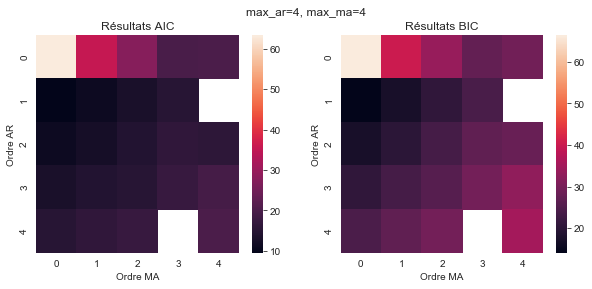

AIC meilleur modèle stationnaire : AR=1, MA=0, AIC=9.517292310173943 
BIC meilleur modèle stationnaire : AR=1, MA=0, BIC=14.096373884022427 
Erreur de prédiction (MSE) : 0.7654369376033835
Erreur de prédiction sur P_rej (MSE) : 0.05428410158676271
Dépassement de la vraie série du seuil ( = significatif) à 0.2
22
Dépassement de la prédiction dynamique du seuil ( = significatif) à 0.2
0
Dépassement de la vraie série du seuil ( = significatif) à 0.1
18
Dépassement de la prédiction dynamique du seuil ( = significatif) à 0.1
0


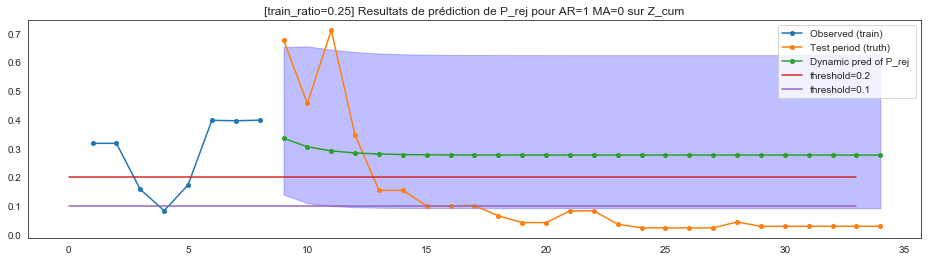

Prédiction de P_rej avec un modèle sur Z_cum with 95% Confidence Interval, train_ratio= 0.5


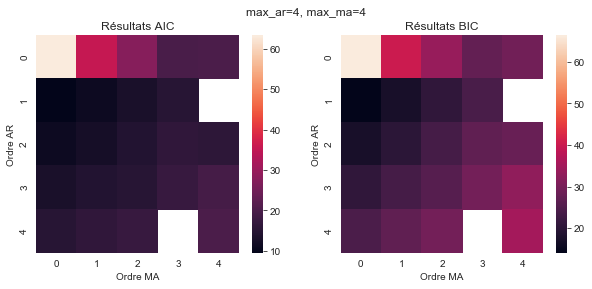

AIC meilleur modèle stationnaire : AR=1, MA=0, AIC=9.517292310173943 
BIC meilleur modèle stationnaire : AR=1, MA=0, BIC=14.096373884022427 
Erreur de prédiction (MSE) : 0.8002818193448505
Erreur de prédiction sur P_rej (MSE) : 0.03407488445107134
Dépassement de la vraie série du seuil ( = significatif) à 0.2
17
Dépassement de la prédiction dynamique du seuil ( = significatif) à 0.2
4
Dépassement de la vraie série du seuil ( = significatif) à 0.1
17
Dépassement de la prédiction dynamique du seuil ( = significatif) à 0.1
0


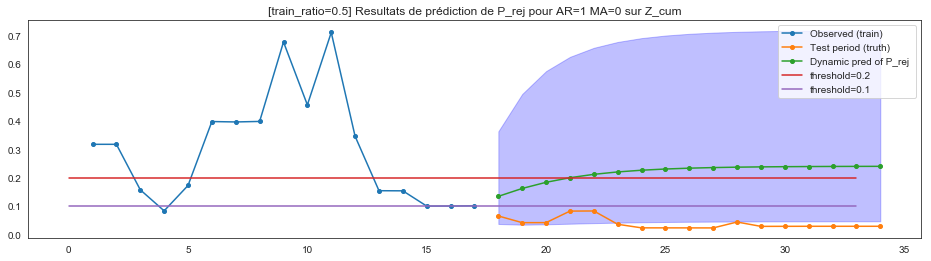

Prédiction de P_rej avec un modèle sur Z_cum with 95% Confidence Interval, train_ratio= 0.65


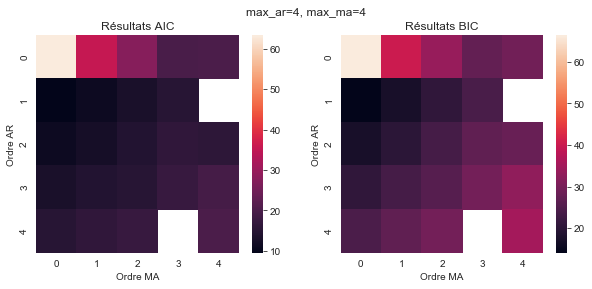

AIC meilleur modèle stationnaire : AR=1, MA=0, AIC=9.517292310173943 
BIC meilleur modèle stationnaire : AR=1, MA=0, BIC=14.096373884022427 
Erreur de prédiction (MSE) : 0.5615413983273218
Erreur de prédiction sur P_rej (MSE) : 0.01496931247050042
Dépassement de la vraie série du seuil ( = significatif) à 0.2
12
Dépassement de la prédiction dynamique du seuil ( = significatif) à 0.2
12
Dépassement de la vraie série du seuil ( = significatif) à 0.1
12
Dépassement de la prédiction dynamique du seuil ( = significatif) à 0.1
1


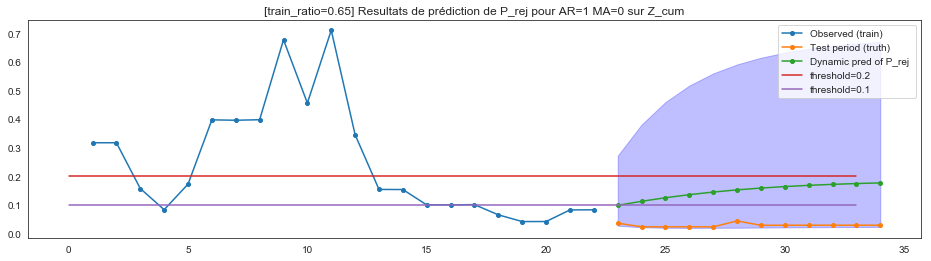

In [37]:
##################################### PARAMETRES #####################################
pred_start = 45  # debut des predictions
pred_end = 100  # fin des predictions
pred_start = 15
pred_end = None
######################################################################################
train_ratio_list = [0.25,0.5,0.65]
for train_ratio in train_ratio_list:
    print("Prédiction de P_rej avec un modèle sur Z_cum with 95% Confidence Interval, train_ratio=", train_ratio)
    
    t = round(train_ratio*len(Z_cum))
    Z_tronq = Z_cum[:t]
    P_tronq = P_rej[:t]
    series = Z_tronq
    
    aic_min_order = arma_model_selection_stationary(series, max_ar=max_ar, max_ma=max_ma)[0]
    
    p_with_fit_of_z(p=aic_min_order[0], q=aic_min_order[1], p_true = P_rej,z_true=Z_cum,
                    train_ratio=train_ratio,signif= True)

### p-valeur

out_of_sample_prediction of P_rej with 95% Confidence Interval, train_ratio= 0.25


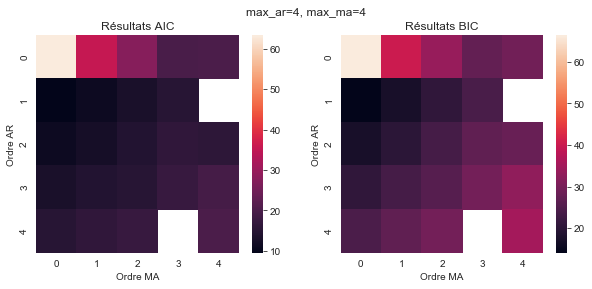

AIC meilleur modèle stationnaire : AR=1, MA=0, AIC=9.517292310173943 
BIC meilleur modèle stationnaire : AR=1, MA=0, BIC=14.096373884022427 
Dépassement de la vraie série du seuil ( = significatif) à 0.2
22
Dépassement de la prédiction dynamique du seuil ( = significatif) à 0.2
0
Dépassement de la vraie série du seuil ( = significatif) à 0.1
18
Dépassement de la prédiction dynamique du seuil ( = significatif) à 0.1
0


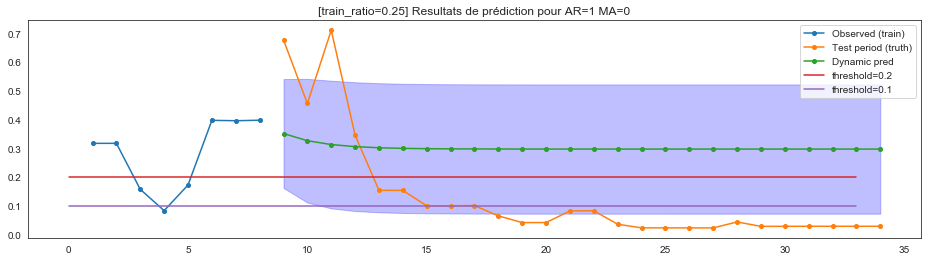

out_of_sample_prediction of P_rej with 95% Confidence Interval, train_ratio= 0.5


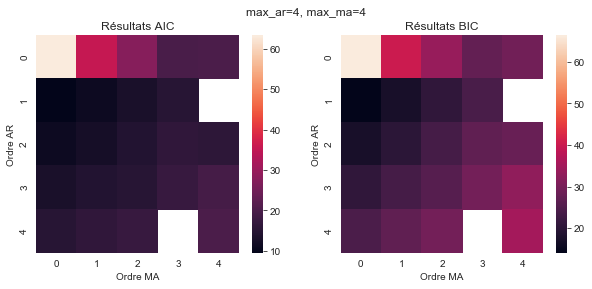

AIC meilleur modèle stationnaire : AR=1, MA=0, AIC=9.517292310173943 
BIC meilleur modèle stationnaire : AR=1, MA=0, BIC=14.096373884022427 
Dépassement de la vraie série du seuil ( = significatif) à 0.2
17
Dépassement de la prédiction dynamique du seuil ( = significatif) à 0.2
1
Dépassement de la vraie série du seuil ( = significatif) à 0.1
17
Dépassement de la prédiction dynamique du seuil ( = significatif) à 0.1
0


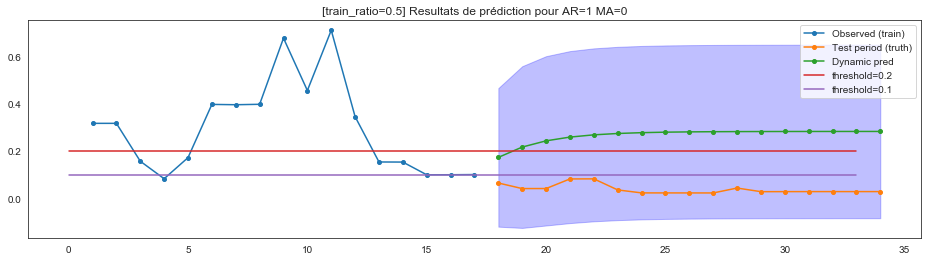

out_of_sample_prediction of P_rej with 95% Confidence Interval, train_ratio= 0.65


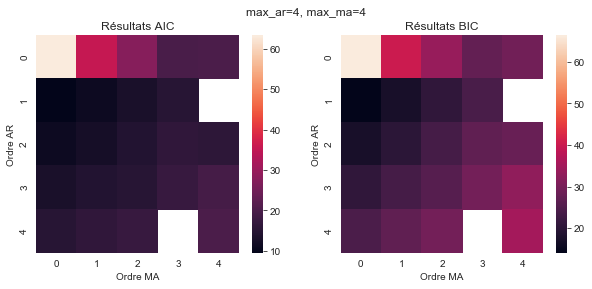

AIC meilleur modèle stationnaire : AR=1, MA=0, AIC=9.517292310173943 
BIC meilleur modèle stationnaire : AR=1, MA=0, BIC=14.096373884022427 
Dépassement de la vraie série du seuil ( = significatif) à 0.2
12
Dépassement de la prédiction dynamique du seuil ( = significatif) à 0.2
4
Dépassement de la vraie série du seuil ( = significatif) à 0.1
12
Dépassement de la prédiction dynamique du seuil ( = significatif) à 0.1
0


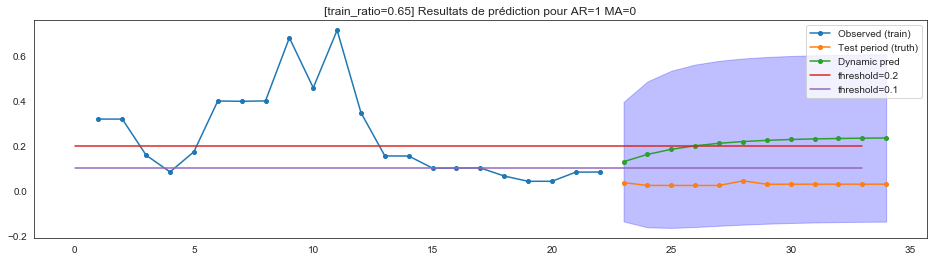

In [38]:
##################################### PARAMETRES #####################################
pred_start = 45  # debut des predictions
pred_end = 100  # fin des predictions
pred_start = 15
pred_end = None
######################################################################################
train_ratio_list = [0.25,0.5,0.65]
for train_ratio in train_ratio_list:
    print("out_of_sample_prediction of P_rej with 95% Confidence Interval, train_ratio=", train_ratio)
    
    t = round(train_ratio*len(Z_cum))
    Z_tronq = Z_cum[:t]
    P_tronq = P_rej[:t]
    series = P_tronq
    
    aic_min_order = arma_model_selection_stationary(series, max_ar=max_ar, max_ma=max_ma)[0]
    
    if train_ratio == 0.65:
        aic_min_order = (1,0)
        
    out_of_sample_prediction(p=aic_min_order[0], q=aic_min_order[1], y_true=P_rej,
                             train_ratio=train_ratio,signif= True)

Globalement, la prédiction reproduit à peu près le même comportement que la p-valeur, qu'elle soit calculée à partir des prédictions de la Z-valeur ou qu'elle soit prédite directement à partir de la p-valeur. Néanmoins, le modèle offre une incertitude qui fait dépasser la p-valeur au-delà des seuils critiques de significativité, si bien qu'il est difficile de statuer sur la qualité des prédictions.

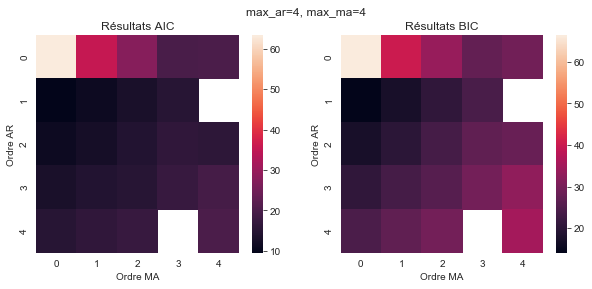

AIC meilleur modèle stationnaire : AR=1, MA=0, AIC=9.517292310173943 
BIC meilleur modèle stationnaire : AR=1, MA=0, BIC=14.096373884022427 


In [16]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

##################################### PARAMETRES #####################################
max_ar = 4
max_ma = 4
######################################################################################

aic_min_order, bic_min_order = arma_model_selection_stationary(series, max_ar=max_ar, max_ma=max_ma)

# Meilleur modèle selon AIC

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   34
Model:                     ARMA(1, 0)   Log Likelihood                  -1.759
Method:                       css-mle   S.D. of innovations              0.249
Date:                Sun, 10 Feb 2019   AIC                              9.517
Time:                        16:18:24   BIC                             14.096
Sample:                             0   HQIC                            11.079
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6084      0.357      4.509      0.000       0.909       2.307
ar.L1.y        0.9042      0.066     13.600      0.000       0.774       1.034
                                    Roots           

## Erreurs sur la période d'entraînement

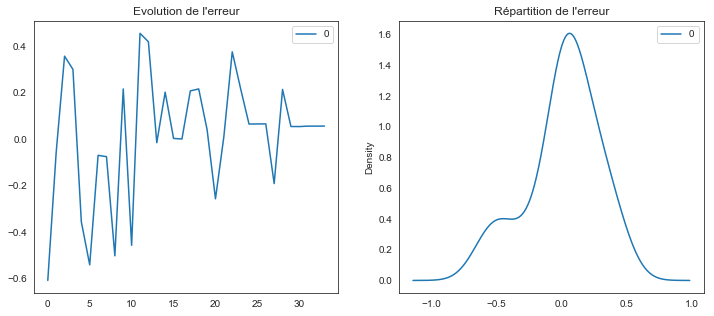

In [17]:
display(Markdown("# Meilleur modèle selon AIC"))
arma_summary(p=aic_min_order[0], q=aic_min_order[1], y_true=series.values)
if aic_min_order != bic_min_order:  
    display(Markdown("# Meilleur modèle selon BIC"))
    arma_summary(p=bic_min_order[0], q=bic_min_order[1], y_true=series.values)

### Zoom sur un modèle en particulier

Pour un modèle donné, est-ce que ce modèle est pertinent ? Regarder les p-valeurs des coefficients. 

Dans cette section on a construit le modèle à partir de l'ensemble des données. Mais quelles sont les prévisions selon le modèle sur les données existantes (in-sample)? 
On réalise des prédictions de `pred_start` à `pred_end` (None donne la fin de la période)
On peut distinguer deux types de prévisions : 
+ 1-step-ahead : on utilise toutes les données jusqu'à J-1
+ Dynamic : à partir de pred_start on utilise les variables prédites comme entrées
    + C'est ce mode qui nous intéresse car on aimerait faire des prédictions pour des horizons lointains sans avoir à faire le test A/B en réel

train_ratio= 0.25


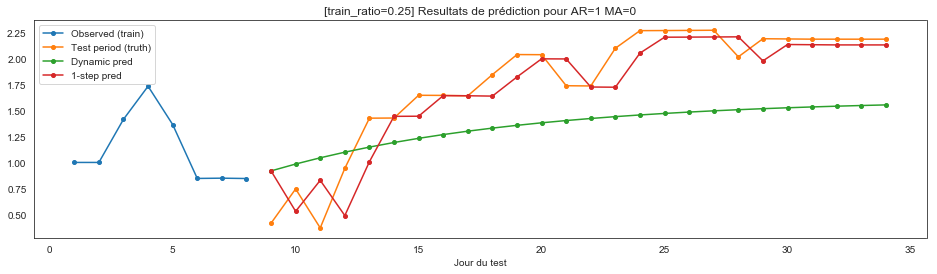

train_ratio= 0.5


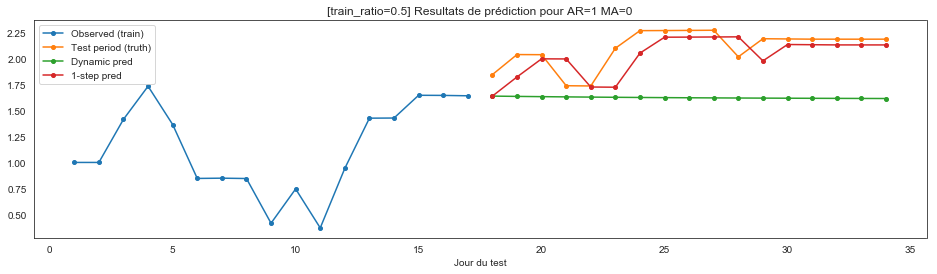

train_ratio= 0.75


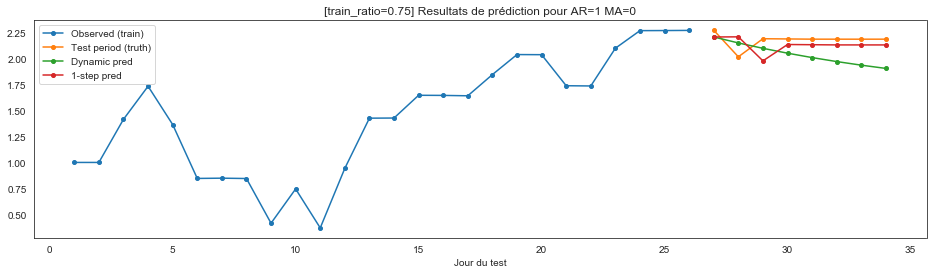

In [18]:
for train_ratio in [0.25, 0.5, 0.75]:
    print("train_ratio=", train_ratio)
    in_sample_prediction(p=aic_min_order[0], q=aic_min_order[1], y_true=series.values, train_ratio=train_ratio)
    if aic_min_order != bic_min_order:    
        in_sample_prediction(p=bic_min_order[0], q=bic_min_order[1], y_true=series.values, train_ratio=train_ratio)

Globalement, la prédiction dynamique semble médiocre dans le sens où elle semble avoir une tendance affine, et ceci quelle que soit la proportion de données prise comme données d'apprentissage (25%, 50%, 75%).

### b. Etude sur la p-value

## Analyse classique d'une ST

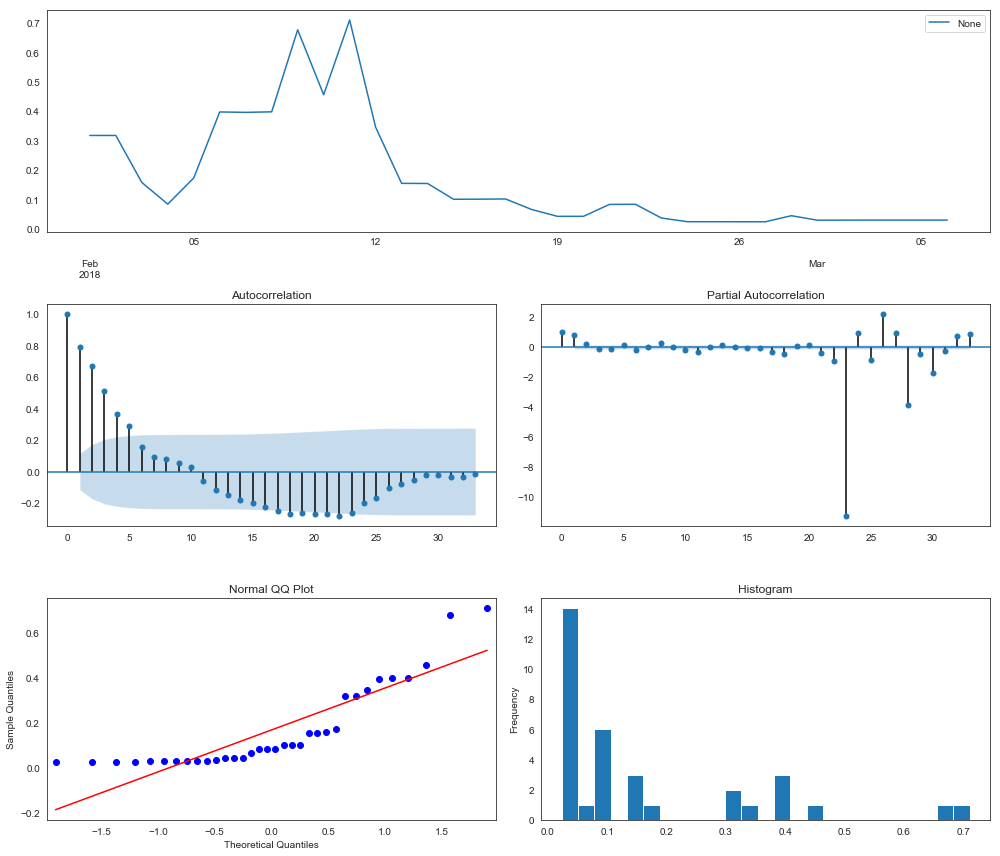

## Décomposition de la série de temps selon modèle multiplicatif

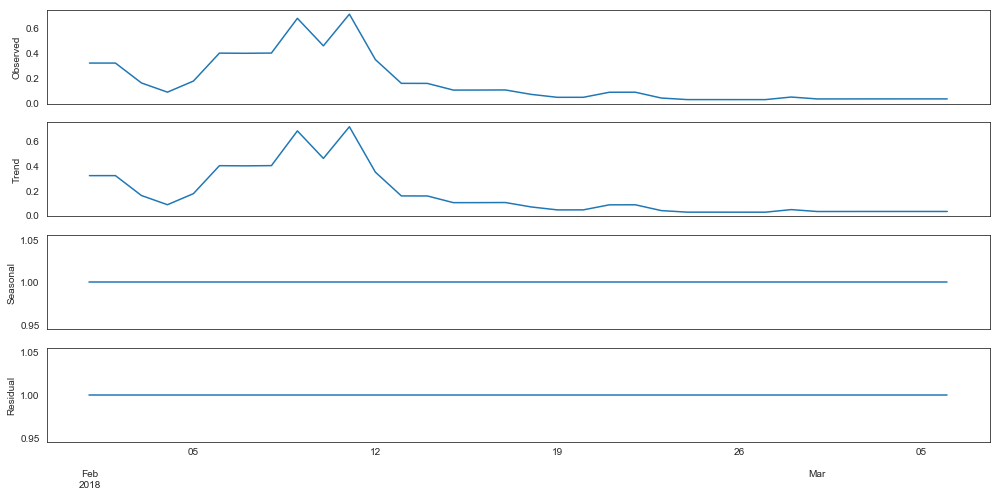

## Test de Dickey-Fuller

,Results of Augmented Dickey-Fuller test:
test statistic,-27.607543
p-value,0.000000
# of lags,10.000000
# of observations,23.000000
Critical Value (1%),-3.752928
Critical Value (5%),-2.998500
Critical Value (10%),-2.638967


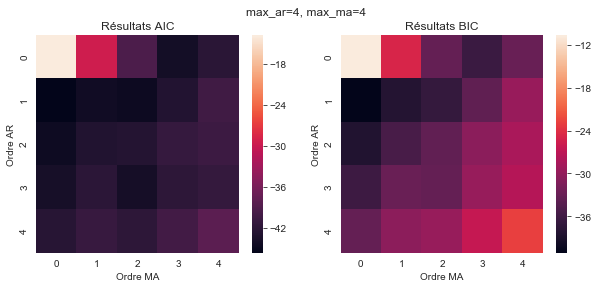

AIC meilleur modèle stationnaire : AR=1, MA=0, AIC=-45.67317512276472 
BIC meilleur modèle stationnaire : AR=1, MA=0, BIC=-41.094093548916234 


# Meilleur modèle selon AIC

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   34
Model:                     ARMA(1, 0)   Log Likelihood                  25.837
Method:                       css-mle   S.D. of innovations              0.112
Date:                Sun, 10 Feb 2019   AIC                            -45.673
Time:                        16:20:39   BIC                            -41.094
Sample:                             0   HQIC                           -44.112
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1686      0.083      2.021      0.052       0.005       0.332
ar.L1.y        0.7928      0.098      8.051      0.000       0.600       0.986
                                    Roots           

## Erreurs sur la période d'entraînement

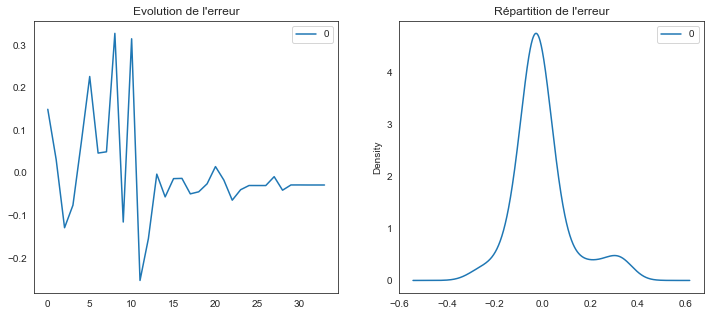

train_ratio= 0.25


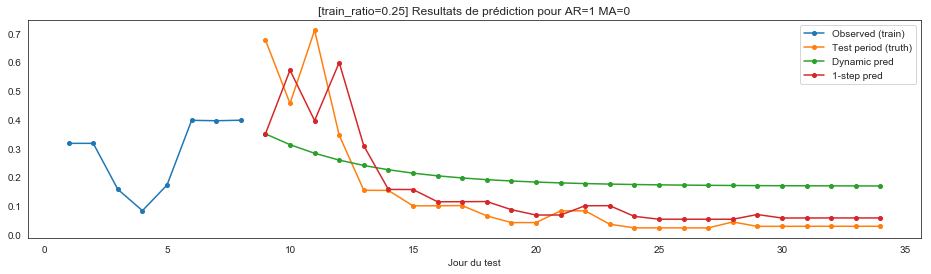

train_ratio= 0.5


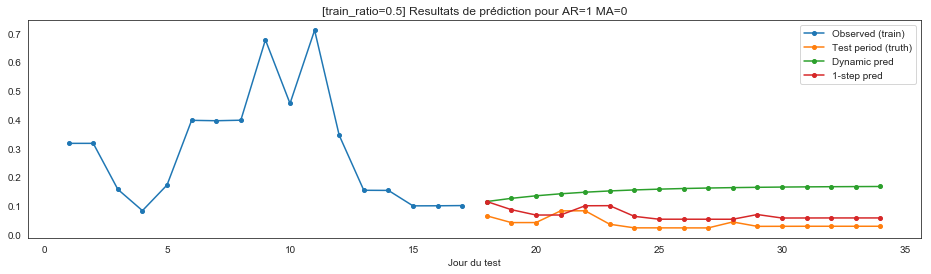

train_ratio= 0.75


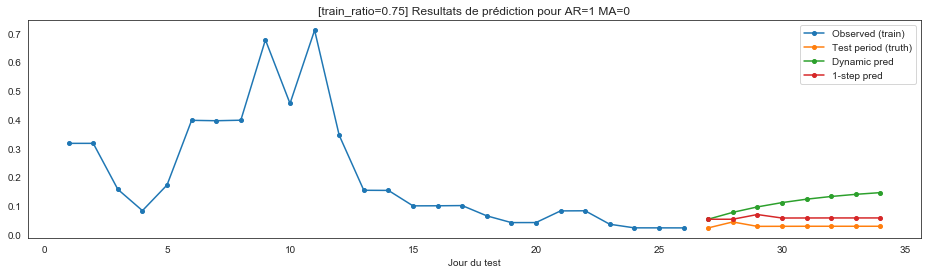

In [19]:
series = pd.Series(p_value_1D)
series.index = daily_cumsum_datasetA.index

analyserZP(series)

##################################### PARAMETRES #####################################
max_ar = 4
max_ma = 4
train_ratio_list = [0.25, 0.5, 0.75]
######################################################################################

aic_min_order, bic_min_order = arma_model_selection_stationary(series, max_ar=max_ar, max_ma=max_ma)

display(Markdown("# Meilleur modèle selon AIC"))
arma_summary(p=aic_min_order[0], q=aic_min_order[1], y_true=series.values)
if aic_min_order != bic_min_order:  
    display(Markdown("# Meilleur modèle selon BIC"))
    arma_summary(p=bic_min_order[0], q=bic_min_order[1], y_true=series.values)
    
for train_ratio in train_ratio_list:
    print("train_ratio=", train_ratio)
    in_sample_prediction(p=aic_min_order[0], q=aic_min_order[1], y_true=series.values, train_ratio=train_ratio)
    if aic_min_order != bic_min_order:
        in_sample_prediction(p=bic_min_order[0], q=bic_min_order[1], y_true=series.values, train_ratio=train_ratio)    

## Fit sur modèle tronqué

Si les résultats en fittant sur l'ensemble des données donnent des prévisions in-sample encore acceptables, nous nous intéressons aux prévisions out-of-sample à présent, si les résultats sont bons cela nous permettra de pouvoir arrêter les tests A/B plus tôt. Nous allons prendre 50% et 75% des données et observer la performance sur les modèles ARMA.

### train_ratio = 0.5

Si on entraîne sur la moitié des données (`train_ratio=0.5`), est-il possible d'avoir quand même un modèle permettant de prédire de manière convaincante la série des Z-valeurs ou des p-valeurs ?. 

In [20]:
Z_cum = pd.Series(Z_value_1D)
Z_cum.index = daily_cumsum_datasetA.index

P_rej = pd.Series(p_value_1D)
P_rej.index = daily_cumsum_datasetA.index

train_ratio = 0.5
t = round(train_ratio * len(Z_cum))
Z_tronq = Z_cum.iloc[0:t]
P_tronq = P_rej.iloc[0:t]

#### a. Etude sur Z

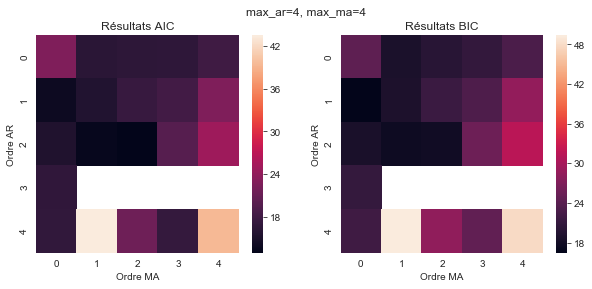

AIC meilleur modèle stationnaire : AR=2, MA=2, AIC=12.888593227977097 
BIC meilleur modèle stationnaire : AR=1, MA=0, BIC=16.440735704025727 


# Meilleur modèle selon AIC

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   17
Model:                     ARMA(2, 2)   Log Likelihood                  -0.444
Method:                       css-mle   S.D. of innovations              0.194
Date:                Sun, 10 Feb 2019   AIC                             12.889
Time:                        16:22:30   BIC                             17.888
Sample:                             0   HQIC                            13.386
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0270      0.026     39.925      0.000       0.977       1.077
ar.L1.y        1.6993      0.060     28.180      0.000       1.581       1.818
ar.L2.y       -0.9678      0.052    -18.727      0.0

## Erreurs sur la période d'entraînement

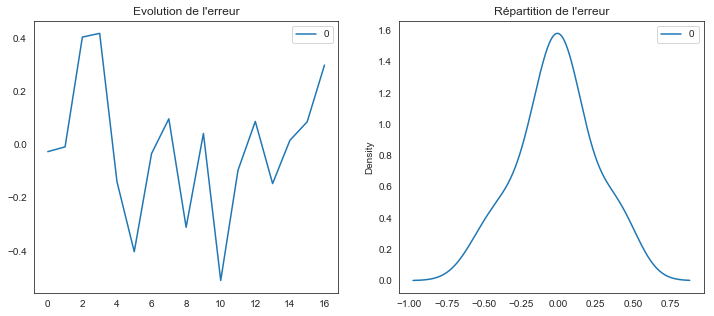

# Meilleur modèle selon BIC

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   17
Model:                     ARMA(1, 0)   Log Likelihood                  -3.971
Method:                       css-mle   S.D. of innovations              0.300
Date:                Sun, 10 Feb 2019   AIC                             13.941
Time:                        16:22:31   BIC                             16.441
Sample:                             0   HQIC                            14.190
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1745      0.212      5.543      0.000       0.759       1.590
ar.L1.y        0.6930      0.167      4.145      0.001       0.365       1.021
                                    Roots           

## Erreurs sur la période d'entraînement

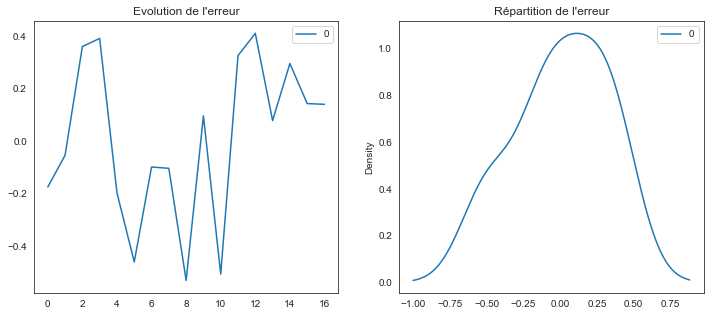

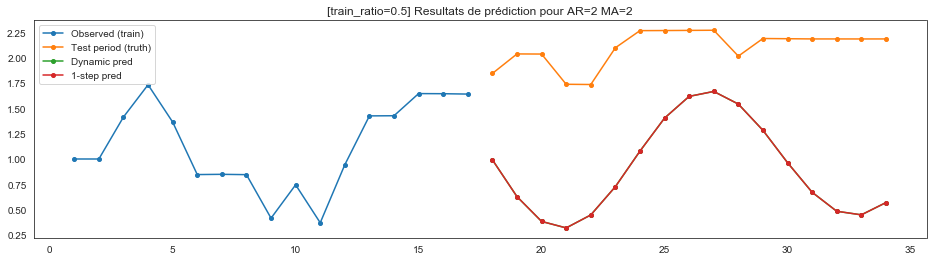

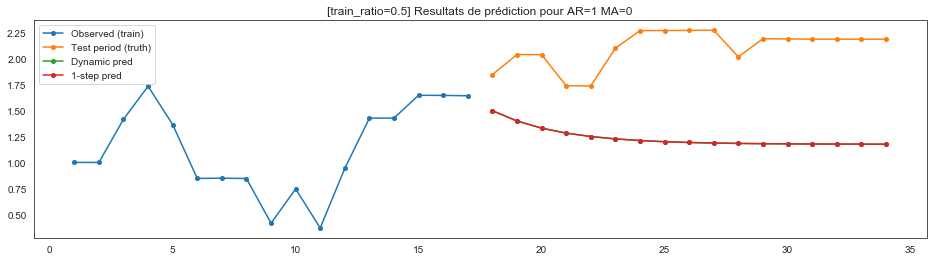

In [21]:
series = Z_tronq
y_true = Z_cum

##################################### PARAMETRES #####################################
max_ar = 4
max_ma = 4
######################################################################################

aic_min_order, bic_min_order = arma_model_selection_stationary(series, max_ar=max_ar, max_ma=max_ma)

display(Markdown("# Meilleur modèle selon AIC"))
arma_summary(p=aic_min_order[0], q=aic_min_order[1], y_true=series.values)
if aic_min_order != bic_min_order:  
    display(Markdown("# Meilleur modèle selon BIC"))
    arma_summary(p=bic_min_order[0], q=bic_min_order[1], y_true=series.values)
    
out_of_sample_prediction(p=aic_min_order[0], q=aic_min_order[1], y_true=y_true, train_ratio=train_ratio)
if aic_min_order != bic_min_order:  
    out_of_sample_prediction(p=bic_min_order[0], q=bic_min_order[1], y_true=y_true, train_ratio=train_ratio)

#### b. Etude sur p

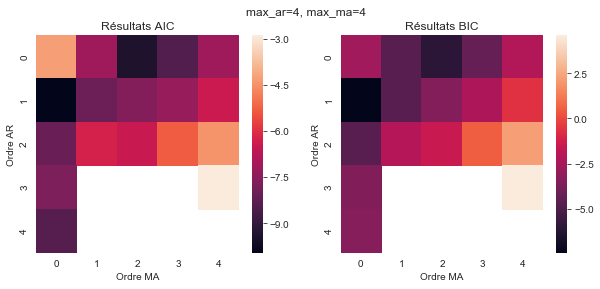

AIC meilleur modèle stationnaire : AR=1, MA=0, AIC=-9.955727130470365 
BIC meilleur modèle stationnaire : AR=1, MA=0, BIC=-7.456087098301715 


# Meilleur modèle selon AIC

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   17
Model:                     ARMA(1, 0)   Log Likelihood                   7.978
Method:                       css-mle   S.D. of innovations              0.149
Date:                Sun, 10 Feb 2019   AIC                             -9.956
Time:                        16:23:03   BIC                             -7.456
Sample:                             0   HQIC                            -9.707
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2831      0.084      3.359      0.004       0.118       0.448
ar.L1.y        0.6019      0.186      3.239      0.006       0.238       0.966
                                    Roots           

## Erreurs sur la période d'entraînement

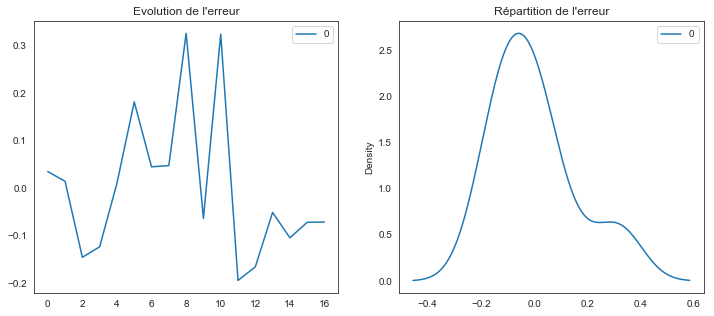

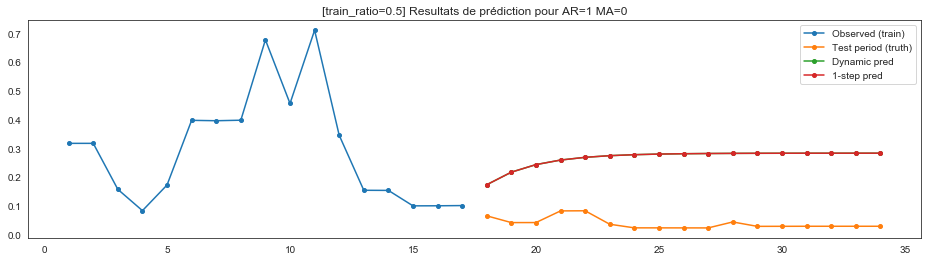

In [22]:
series = P_tronq
y_true = P_rej

##################################### PARAMETRES #####################################
max_ar = 4
max_ma = 4
######################################################################################

aic_min_order, bic_min_order = arma_model_selection_stationary(series, max_ar=max_ar, max_ma=max_ma)

display(Markdown("# Meilleur modèle selon AIC"))
arma_summary(p=aic_min_order[0], q=aic_min_order[1], y_true=series.values)
if aic_min_order != bic_min_order:  
    display(Markdown("# Meilleur modèle selon BIC"))
    arma_summary(p=bic_min_order[0], q=bic_min_order[1], y_true=series.values)
    
out_of_sample_prediction(p=aic_min_order[0], q=aic_min_order[1], y_true=y_true.values, train_ratio=train_ratio)
if aic_min_order != bic_min_order:  
    out_of_sample_prediction(p=bic_min_order[0], q=bic_min_order[1], y_true=y_true.values, train_ratio=train_ratio)

### train_ratio = 0.75
On entraîne sur 75% des données (`train_ratio=0.75`). 

In [23]:
Z_cum = pd.Series(Z_value_1D)
Z_cum.index = daily_cumsum_datasetA.index

P_rej = pd.Series(p_value_1D)
P_rej.index = daily_cumsum_datasetA.index

train_ratio = 0.75
t = round(train_ratio * len(Z_cum))
Z_tronq = Z_cum[0:t]
P_tronq = P_rej[0:t]

#### a. Etude sur Z

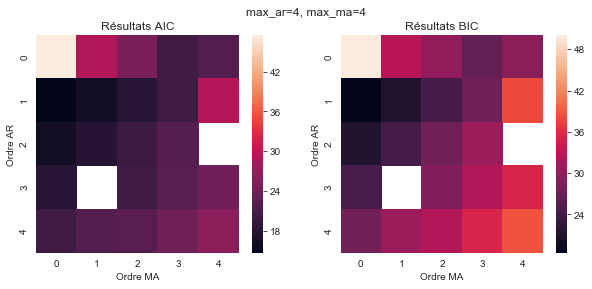

AIC meilleur modèle stationnaire : AR=1, MA=0, AIC=14.654079647855482 
BIC meilleur modèle stationnaire : AR=1, MA=0, BIC=18.42836926191993 


# Meilleur modèle selon AIC

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   26
Model:                     ARMA(1, 0)   Log Likelihood                  -4.327
Method:                       css-mle   S.D. of innovations              0.278
Date:                Sun, 10 Feb 2019   AIC                             14.654
Time:                        16:23:56   BIC                             18.428
Sample:                             0   HQIC                            15.741
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5131      0.360      4.199      0.000       0.807       2.219
ar.L1.y        0.8781      0.089      9.904      0.000       0.704       1.052
                                    Roots           

## Erreurs sur la période d'entraînement

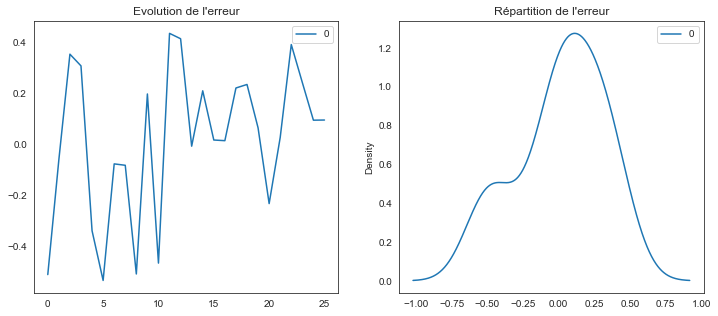

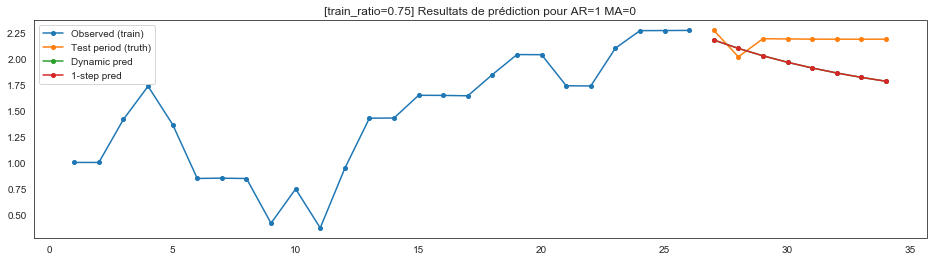

In [24]:
series = Z_tronq
y_true = Z_cum

##################################### PARAMETRES #####################################
max_ar = 4
max_ma = 4
######################################################################################

aic_min_order, bic_min_order = arma_model_selection_stationary(series, max_ar=max_ar, max_ma=max_ma)

display(Markdown("# Meilleur modèle selon AIC"))
arma_summary(p=aic_min_order[0], q=aic_min_order[1], y_true=series.values)
if aic_min_order != bic_min_order:  
    display(Markdown("# Meilleur modèle selon BIC"))
    arma_summary(p=bic_min_order[0], q=bic_min_order[1], y_true=series.values)
    
out_of_sample_prediction(p=aic_min_order[0], q=aic_min_order[1], y_true=y_true, train_ratio=train_ratio)
if aic_min_order != bic_min_order:  
    out_of_sample_prediction(p=bic_min_order[0], q=bic_min_order[1], y_true=y_true, train_ratio=train_ratio)

#### b. Etude sur p

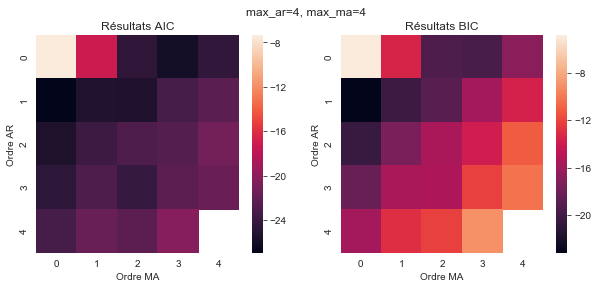

AIC meilleur modèle stationnaire : AR=1, MA=0, AIC=-26.951120025084194 
BIC meilleur modèle stationnaire : AR=1, MA=0, BIC=-23.176830411019747 


# Meilleur modèle selon AIC

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   26
Model:                     ARMA(1, 0)   Log Likelihood                  16.476
Method:                       css-mle   S.D. of innovations              0.126
Date:                Sun, 10 Feb 2019   AIC                            -26.951
Time:                        16:24:24   BIC                            -23.177
Sample:                             0   HQIC                           -25.864
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2025      0.089      2.264      0.033       0.027       0.378
ar.L1.y        0.7500      0.123      6.122      0.000       0.510       0.990
                                    Roots           

## Erreurs sur la période d'entraînement

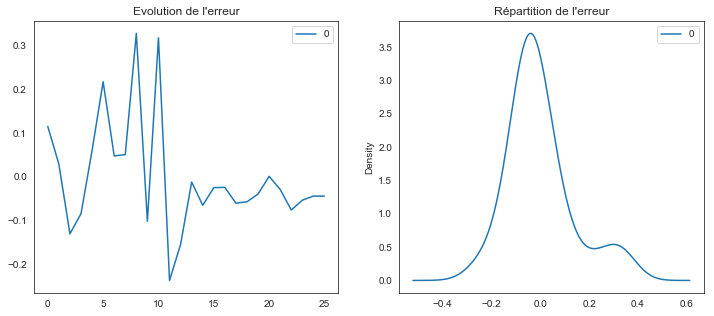

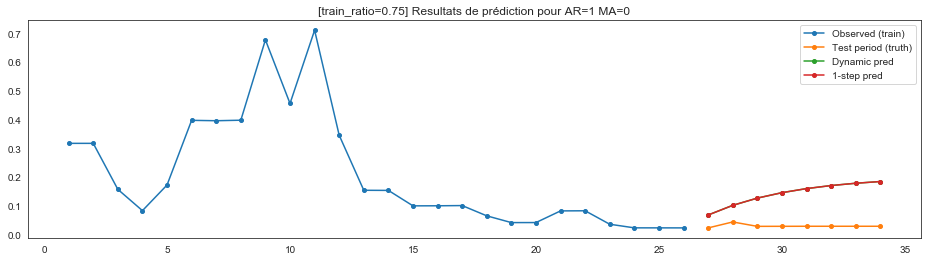

In [25]:
series = P_tronq
y_true = P_rej

##################################### PARAMETRES #####################################
max_ar = 4
max_ma = 4
######################################################################################

aic_min_order, bic_min_order = arma_model_selection_stationary(series, max_ar=max_ar, max_ma=max_ma)

display(Markdown("# Meilleur modèle selon AIC"))
arma_summary(p=aic_min_order[0], q=aic_min_order[1], y_true=series.values)
if aic_min_order != bic_min_order:  
    display(Markdown("# Meilleur modèle selon BIC"))
    arma_summary(p=bic_min_order[0], q=bic_min_order[1], y_true=series.values)
    
out_of_sample_prediction(p=aic_min_order[0], q=aic_min_order[1], y_true=y_true.values, train_ratio=train_ratio)
if aic_min_order != bic_min_order:  
    out_of_sample_prediction(p=bic_min_order[0], q=bic_min_order[1], y_true=y_true.values, train_ratio=train_ratio)